## Bank Marketing Campaing

### Goal
Determine the best client selection strategy for a Portuguesse banking insitution to sell long term deposits bia telemarketing.

### Type of problem
This is a **classification** problem, with a binary target variable determininng if the client has bought a term deposit or not




Import the different libraries

In [768]:
%reset -f

In [769]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [770]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [771]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['font.size'] = 14

plt.rcParams['lines.markersize'] = 8

In [772]:
### Flags
save_figs = True

In [773]:
from sklearn.base import clone

In [774]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, ShuffleSplit, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

### Models

In [775]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.naive_bayes import GaussianNB

In [936]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score

In [777]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint, uniform, loguniform
from sklearn.tree import plot_tree

In [915]:
import eli5

C:\Users\User\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## Custom code for Tree prunning and plots

In [15]:
from mlgtsrc import bank_data, plots
import os
import pickle

In [964]:
OUTFIGURES = "../../report/figures/bank"

## Initial Data Exploration

#### Data downloaded from UCI Machine Learning Repository
https://archive.ics.uci.edu/ml/datasets/bank+marketing

Source: [Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

Note: UCI offers two files, bank-full.csv (full data set), and bank.csv, which is a 10% subset of bank-full, provided for testing purposes. We will use bank-full and create our own testing set

In [780]:
src = "./data/uci/bank-full.csv"
raw = pd.read_csv(src, sep=";")

In [781]:
raw

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


There are 45,211 instances, with 16 attributes

### Attributes description

Input variables (from bank-names.txt)


Bank client data:

1 - age (numeric)

2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                   "blue-collar","self-employed","retired","technician","services") 
                                   
3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric) 

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")

Related with the last contact of the current campaign:

9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)

Other attributes:
13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):
17 - y - has the client subscribed a term deposit? (binary: "yes","no")

### Determine if there are any missing data

In [782]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


There is no missing data, so imputation is needed

Count number of numerical vs categorical attributes

In [783]:
raw.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [784]:
cols = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome']
variable_types = pd.Series(data = [raw.loc[:, col].dtype for col in cols], 
          index = cols)
variable_types = variable_types.sort_values()
variable_types.value_counts()

object    9
int64     7
dtype: int64

### Look at the distribution of the target variable

In [785]:
target_counts = raw.loc[:, 'y'].value_counts()
target_counts = target_counts.to_frame()
target_counts.columns = ['Counts']
target_counts.index.name = 'output'
target_counts

,Counts
output,
no,39922
yes,5289


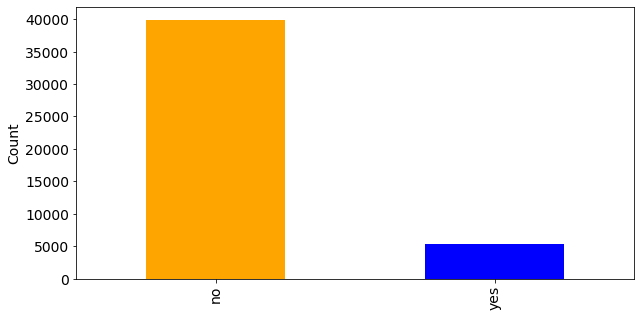

In [786]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
raw.loc[:, 'y'].value_counts().plot(ax = ax, kind = 'bar', color = ['orange', 'blue'])
ax.set_ylabel('Count')
if save_figs:
    fig.savefig("../../report/figures/target_variable_distribution.png")

In [787]:
target_counts = raw.loc[:, 'y'].value_counts()

In [788]:
target_counts.loc["yes"]/target_counts.sum()

0.11698480458295547

### Look at the distribution of each of the attributes with the target variable 

### Efect of duration

The website states that duration should be excluded from the analysis. Let's check that the is the case, by plotting it against the target variable

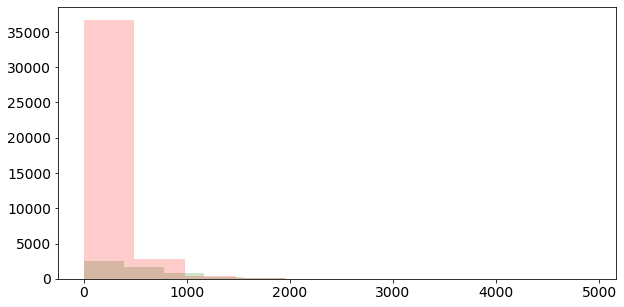

In [789]:
attribute = 'duration'
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
for decision, color in zip(['yes', 'no'], ['green', 'red']):
    mask = raw.loc[:, 'y']==decision
    ax.hist(raw.loc[mask, attribute], color = color, alpha = 0.2)

<font color = 'red' size = 3> Remove duration from the data

In [790]:
raw = raw.drop('duration', axis = 1)
raw.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous',
       'poutcome', 'y'],
      dtype='object')

In [791]:
cols = raw.columns
variable_types = pd.Series(data = [raw.loc[:, col].dtype for col in cols], 
          index = cols)
variable_types = variable_types.sort_values()
variable_types

age           int64
balance       int64
day           int64
campaign      int64
pdays         int64
previous      int64
job          object
marital      object
education    object
default      object
housing      object
loan         object
contact      object
month        object
poutcome     object
y            object
dtype: object

In [792]:
variable_types.loc[variable_types==np.int64]

age         int64
balance     int64
day         int64
campaign    int64
pdays       int64
previous    int64
dtype: object

In [793]:
all_x_columns = list(raw.columns)
all_x_columns

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'y']

In [794]:
x_cols = ['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'campaign',
 'pdays',
 'previous',
 'poutcome']

y_col = ['y']

### Categorical columns

In [795]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

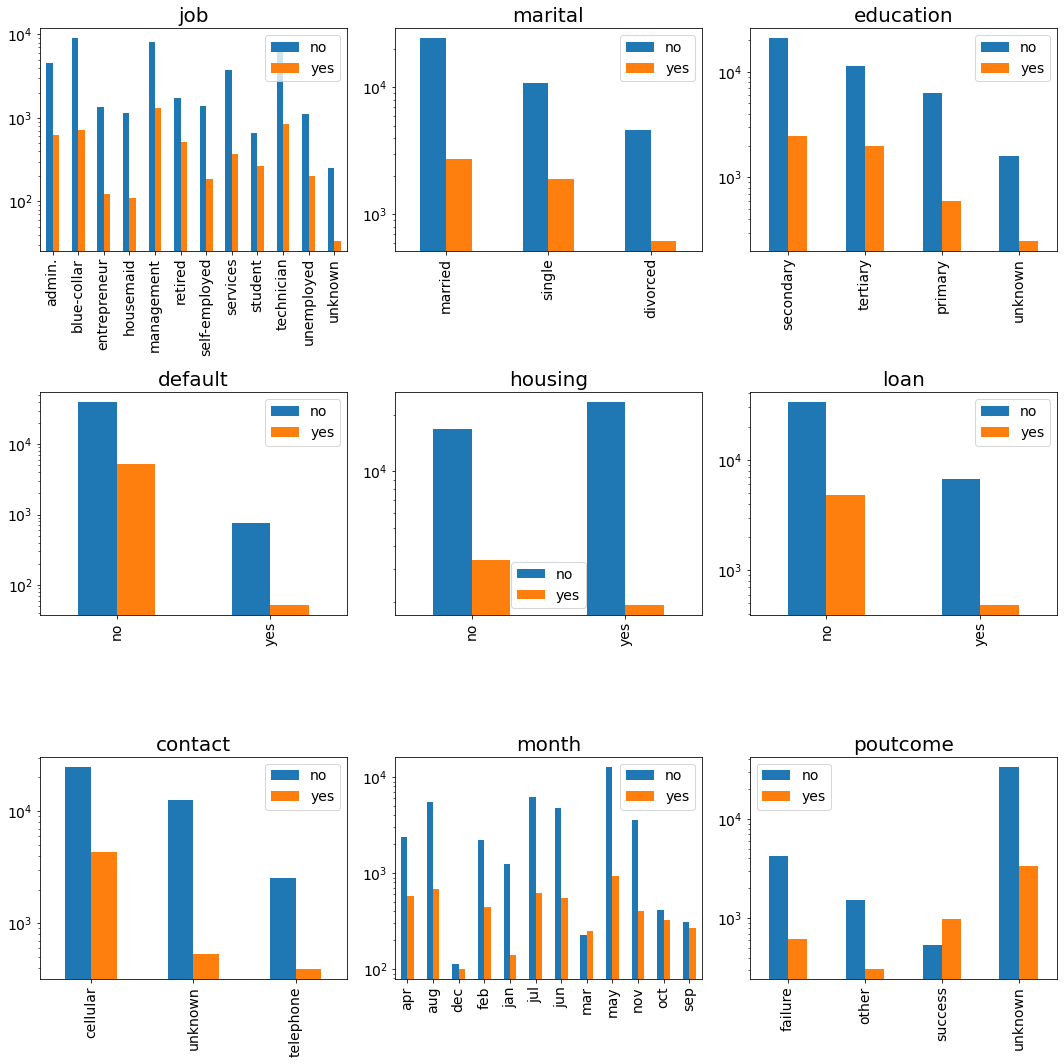

In [796]:
fig = plt.figure(figsize = (15, 15))

for idx, attribute in enumerate(cat_columns):
    if attribute !='y':
        
        ax = fig.add_subplot(3, 3, idx+1)
        
        data_attr = raw.loc[:, [attribute, 'y']]                
        # It is a categorical variable, do a bar plot

        df = pd.DataFrame(data = {"yes": data_attr.loc[data_attr.loc[:, 'y']=='yes', attribute].value_counts(),
                     "no": data_attr.loc[data_attr.loc[:, 'y']=='no', attribute].value_counts()})

        df.loc[:, ['no', 'yes']].plot(ax = ax, kind = 'bar')
        ax.set_title(attribute, size = 20)
        
        ax.legend(fontsize = 14)
        
        ax.set_yscale('log')

fig.tight_layout()    
if save_figs:
    fig.savefig("../../report/figures/target_variable_cat_distribution.png")
        

The following variables seem to be an effect on the target variable

Of those that did default, how many end up accepting a term loan?

In [797]:
attribute = 'default'
attr = raw.loc[:, [attribute, 'y']].copy()
val_counts = attr.loc[attr.loc[:, attribute]=='yes', 'y'].value_counts()
val_counts.sum()

815

In [798]:
val_counts

no     763
yes     52
Name: y, dtype: int64

In [799]:
val_counts.loc['yes']/val_counts.sum()

0.0638036809815951

How does it compare to those that did not default, how many end up accepting a term loan?

In [800]:
attribute = 'default'
attr = raw.loc[:, [attribute, 'y']].copy()
val_counts = attr.loc[attr.loc[:, attribute]=='no', 'y'].value_counts()
val_counts.sum()

44396

In [801]:
val_counts

no     39159
yes     5237
Name: y, dtype: int64

In [802]:
val_counts.loc['yes']/val_counts.sum()

0.11796107757455626

What about loans?

In [803]:
attribute = 'loan'
attr = raw.loc[:, [attribute, 'y']].copy()
val_counts = attr.loc[attr.loc[:, attribute]=='yes', 'y'].value_counts()
val_counts.sum()

7244

In [804]:
val_counts.loc['yes']/val_counts.sum()

0.06681391496410823

In [805]:
attribute = 'loan'
attr = raw.loc[:, [attribute, 'y']].copy()
val_counts = attr.loc[attr.loc[:, attribute]=='no', 'y'].value_counts()
val_counts.sum()

37967

In [806]:
val_counts.loc['yes']/val_counts.sum()

0.12655727342165565

In [807]:
default = raw.loc[:, ['default', 'y']].copy()
default.loc[:, 'y'] = [True if y=='yes' else False for y in default.loc[:, 'y']]
grouped =default.loc[default.loc[:, 'y'], :].groupby('default').sum()
grouped.loc[:, 'y']/grouped.loc[:, 'y'].sum()

default
no     0.990168
yes    0.009832
Name: y, dtype: float64

In [808]:
default = raw.loc[:, ['loan', 'y']].copy()
default.loc[:, 'y'] = [True if y=='yes' else False for y in default.loc[:, 'y']]
grouped =default.loc[default.loc[:, 'y'], :].groupby('loan').sum()
grouped.loc[:, 'y']/grouped.loc[:, 'y'].sum()

loan
no     0.908489
yes    0.091511
Name: y, dtype: float64

In [809]:
grouped.loc[:, 'y'].sum()

5289

In [810]:
grouped.loc[:, 'y'].sum()

5289

### Numerical columns

In [811]:
variable_types.loc[variable_types==np.int64]

age         int64
balance     int64
day         int64
campaign    int64
pdays       int64
previous    int64
dtype: object

In [812]:
variable_types.loc[variable_types==np.int64].index

Index(['age', 'balance', 'day', 'campaign', 'pdays', 'previous'], dtype='object')

In [813]:
num_columns = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']

<AxesSubplot:xlabel='balance', ylabel='Count'>

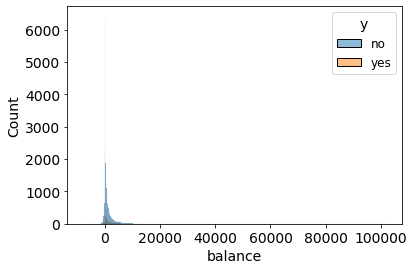

In [814]:
sns.histplot(data=raw, x="balance", hue="y")

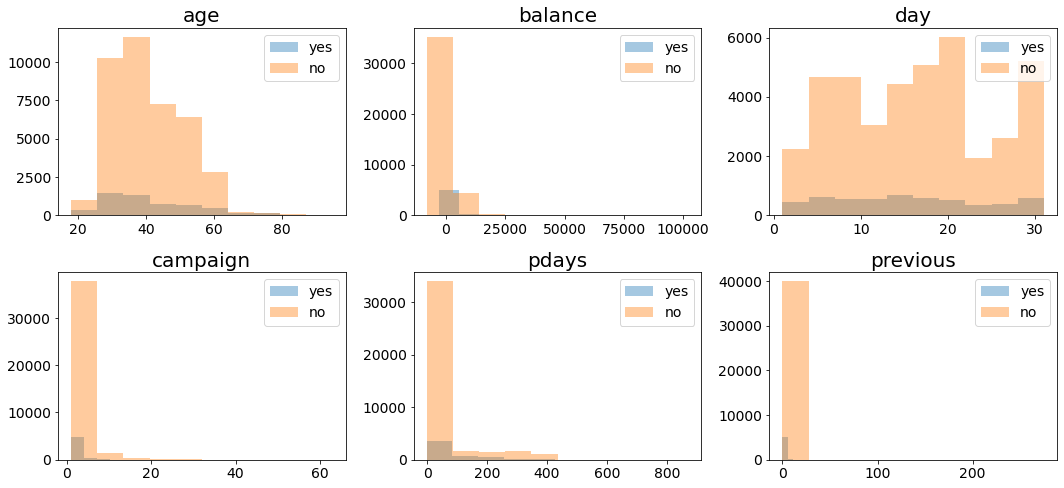

In [815]:
fig = plt.figure(figsize = (15, 7))

for idx, attribute in enumerate(num_columns):
    if attribute !='y':
        
        ax = fig.add_subplot(2, 3, idx+1)
        
        data_attr = raw.loc[:, [attribute, 'y']]                
        # It is a numerical variable, do a histogram plot
        for decision, color in zip(['yes', 'no'], ['orange', 'blue']):
            mask = data_attr.loc[:, 'y']==decision
            ax.hist(data_attr.loc[mask, attribute], alpha = 0.4)
     
        ax.set_title(attribute, size = 20)
        
        ax.legend(["yes", "no"], fontsize = 14)
               

fig.tight_layout()    
if save_figs:
    fig.savefig("../../report/figures/target_variable_num_distribution.png")
        

### Stratified sampling

Given the importance of the loan variable from the analysis above, perform a Stratified Sampling based on it

In [816]:
# Here we split the data into training and test sets and implement a stratified shuffle split.
test_size = .10
stratified = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=1)

for train_set, test_set in stratified.split(raw, raw["loan"]):
    stratified_train = raw.loc[train_set]
    stratified_test = raw.loc[test_set]

In [817]:
def loan_cat_proportions(data):
    return data["loan"].value_counts() / len(data)

train_set, test_set = train_test_split(raw, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": loan_cat_proportions(raw),
    "Stratified": loan_cat_proportions(stratified_test),
    "Random": loan_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props.index.name = 'Has loan?'

In [818]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
Has loan?,,,,,
no,0.839774,0.839673,0.844189,0.525781,-0.012003
yes,0.160226,0.160327,0.155811,-2.755705,0.062908


### Data representation 

1. Encode categorical variables into one-hot encoding

2. Scale numerical variables, since there s a wide dispersion of their values

Look at the range of the numerical variables

In [819]:
stratified_train.describe()

,age,balance,day,campaign,pdays,previous
count,40689.000000,40689.000000,40689.000000,40689.000000,40689.000000,40689.000000
mean,40.934896,1358.452309,15.825383,2.762172,40.367053,0.582270
std,10.632981,3034.443003,8.323889,3.092792,100.361546,2.345988
min,18.000000,-8019.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,1.000000,-1.000000,0.000000
50%,39.000000,450.000000,16.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,63.000000,854.000000,275.000000


In [820]:
cat_columns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [821]:
# Make the pipelines: alternative
preprocess_pipeline = ColumnTransformer([
        ("numerical_pipeline", StandardScaler(), num_columns),
        ("categorical_pipeline", OneHotEncoder(), cat_columns),
    ])

Transform the train and test sets

In [822]:
stratified_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
23781,31,management,single,tertiary,no,58,no,no,cellular,29,aug,2,-1,0,unknown,no
28570,30,technician,single,secondary,no,133,yes,no,cellular,29,jan,2,-1,0,unknown,no
13882,31,technician,married,secondary,no,0,yes,yes,cellular,10,jul,1,-1,0,unknown,no
437,35,management,single,tertiary,no,560,yes,no,unknown,6,may,1,-1,0,unknown,no
687,53,admin.,married,secondary,no,244,yes,yes,unknown,6,may,2,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5883,52,entrepreneur,divorced,secondary,no,-99,no,yes,unknown,26,may,3,-1,0,unknown,no
28818,32,services,divorced,secondary,no,130,yes,no,cellular,30,jan,3,-1,0,unknown,no
41765,59,unemployed,married,secondary,no,0,no,no,cellular,13,oct,1,216,1,failure,no
21698,33,management,single,tertiary,no,0,no,no,cellular,19,aug,4,-1,0,unknown,no


#### Transform the train variables

In [823]:
X_train = preprocess_pipeline.fit_transform(stratified_train.loc[:, x_cols])

For the y-variable, since it is binary, let's do a simple LabelEncoder

In [824]:
label_encoder = LabelEncoder()
y_train =  label_encoder.fit_transform(stratified_train.loc[:, y_col])

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [825]:
X_train.shape

(40689, 50)

In [826]:
X_train

array([[-0.93435875, -0.42856903,  1.58276737, ...,  0.        ,
         0.        ,  1.        ],
       [-1.02840691, -0.40385249,  1.58276737, ...,  0.        ,
         0.        ,  1.        ],
       [-0.93435875, -0.44768315, -0.69984772, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.6989898 , -0.44768315, -0.33943481, ...,  0.        ,
         0.        ,  0.        ],
       [-0.74626243, -0.44768315,  0.38139101, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.13470082,  0.27436927,  1.58276737, ...,  0.        ,
         0.        ,  1.        ]])

In [827]:
y_train.sum()

4711

In [828]:
y_train.sum()/len(y_train)

0.11578067782447345

In [829]:
100.0-11.7

88.3

#### Transform the test variables

<font color = 'red' size 3> Important, only transform on test data, do not do fit_transform, so that you are not using the test data to transform it

In [830]:
X_test = preprocess_pipeline.transform(stratified_test.loc[:, x_cols])

For the y-variable, since it is binary, let's do a simple LabelEncoder

In [836]:
y_test =  label_encoder.transform(stratified_test.loc[:, y_col].values.reshape(-1, ))

### Decision Trees

In [144]:
treeclf = DecisionTreeClassifier(max_depth = 20)

#### Plot performance on both training and test set as a function of training size

In [145]:
numTrainSamples = X_train.shape[0]

In [146]:
train_sizes = np.linspace(0.1*numTrainSamples, numTrainSamples, 20)

In [147]:
train_indexes = [int(x) for x in train_sizes]

In [165]:
tree_learning_curve = pd.DataFrame(index = train_indexes, columns = ["AUC - Train", "AUC - Test"])
for idx in train_indexes:
    sub_x_train = X_train[:idx, :]
    sub_y_train = y_train[:idx]                    
    treeclf.fit(sub_x_train, sub_y_train)
    
    # Test in-sample fit
    y_scores = treeclf.predict_proba(sub_x_train)    
    in_sample_auc = roc_auc_score(sub_y_train, y_scores[:, 1])
    
    # Test out of sample fit
    y_scores_test = treeclf.predict_proba(X_test)    
    out_sample_auc = roc_auc_score(y_test, y_scores_test[:, 1])
    
    tree_learning_curve.loc[idx, "AUC - Train"] = in_sample_auc
    tree_learning_curve.loc[idx, "AUC - Test"] = out_sample_auc
    

Text(0.5, 1.0, 'Tree classifier learing curve')

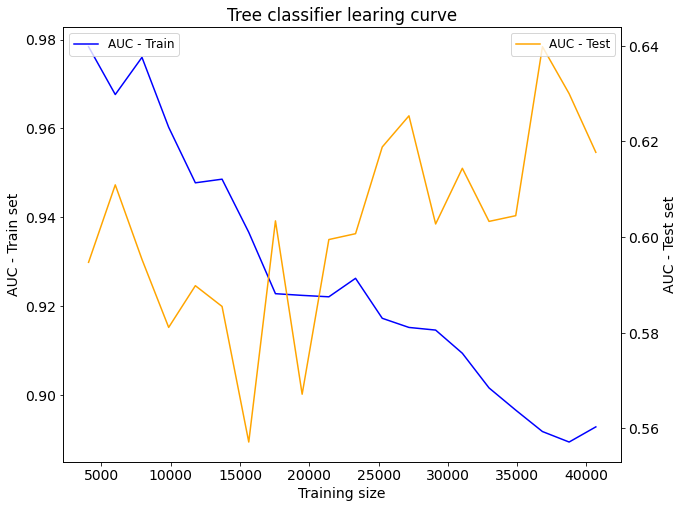

In [171]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
tree_learning_curve.loc[:, ["AUC - Train"]].plot(ax = ax, color = 'blue')
ax.set_ylabel("AUC - Train set")
ax.legend(loc = 'upper left')

ax2 = ax.twinx()
tree_learning_curve.loc[:, ["AUC - Test"]].plot(ax = ax2, color = 'orange')
ax2.set_ylabel("AUC - Test set")
ax2.legend(loc = 'upper right')

ax.set_xlabel("Training size")
ax.set_title("Tree classifier learing curve")

In [172]:
# Plot the learning curve using the example from:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

array([<AxesSubplot:title={'center':'Learning Curves (Decision Tree)'}, xlabel='Training examples', ylabel='Score'>,
       <AxesSubplot:title={'center':'Scalability of the model'}, xlabel='Training examples', ylabel='fit_times'>,
       <AxesSubplot:title={'center':'Performance of the model'}, xlabel='fit_times', ylabel='Score'>],
      dtype=object)

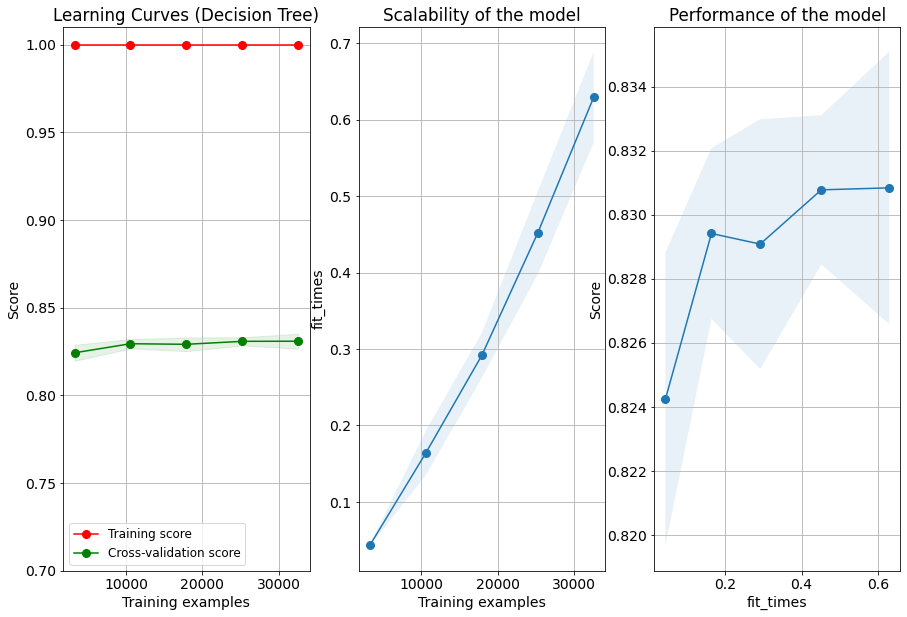

In [176]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = DecisionTreeClassifier()

title = "Learning Curves (Decision Tree)"
bank_data.plot_learning_curve(
    estimator, title, X_train, y_train, axes=axes, ylim=(0.7, 1.01), cv=cv, n_jobs=4
)



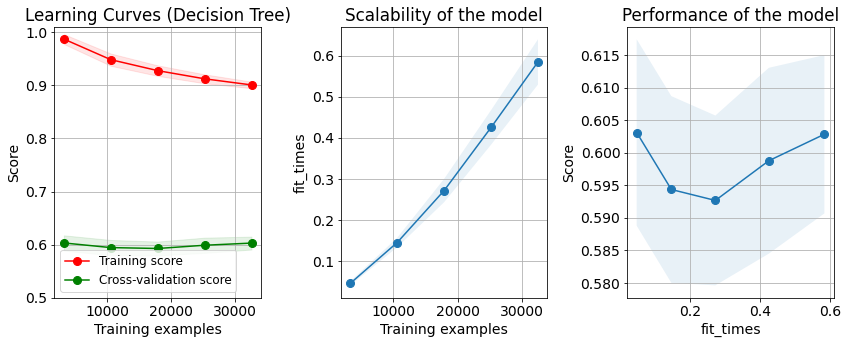

In [192]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = DecisionTreeClassifier(max_depth = 20)

train_sizes=np.linspace(0.1, 1.0, 5)

scoring = 'roc_auc'

title = "Learning Curves (Decision Tree)"
bank_data.plot_learning_curve(
    estimator, title, X_train, y_train, axes=axes, ylim=(0.5, 1.01), cv=cv, n_jobs=4, train_sizes = train_sizes,
    scoring = scoring
)

fig.tight_layout()

Would it make sense to include this plot at the very end, once I have found the best algorithm across a set of hyper-parameters?

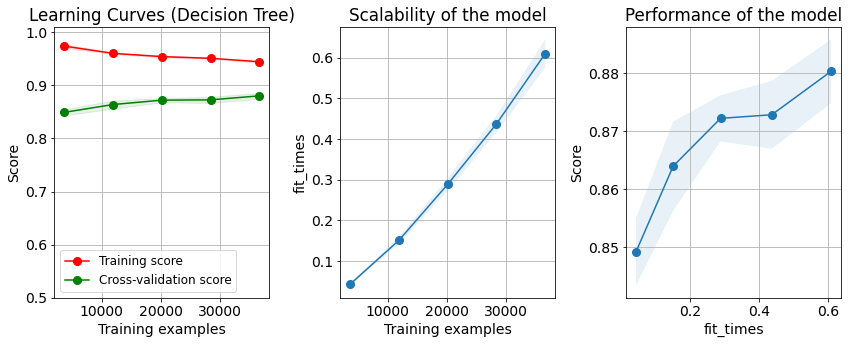

In [215]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

#cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
cv = KFold(n_splits=10)

estimator = DecisionTreeClassifier(max_depth = 20)

train_sizes=np.linspace(0.1, 1.0, 5)

scoring = 'accuracy'

title = "Learning Curves (Decision Tree)"
bank_data.plot_learning_curve(
    estimator, title, X_train, y_train, axes=axes, ylim=(0.5, 1.01), cv=cv, n_jobs=4, train_sizes = train_sizes,
    scoring = scoring
)

fig.tight_layout()

<font color = 'blue' size = 4> Without specification on scoring, scikit-learn learning_curve computes the accuracy as a metric

### Get an idea for adjusting ccp_alpha

In [ ]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py

In [236]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas_raw, impurities_raw = path.ccp_alphas, path.impurities

In [237]:
ccp_alphas

array([0.00000000e+00, 9.61695662e-06, 9.66404529e-06, 9.78638448e-06])

In [238]:
impurities

array([0.00000000e+00, 4.80847831e-05, 9.64050096e-05, ...,
       1.82307785e-01, 1.85502558e-01, 2.04751025e-01])

In [239]:
len(impurities)

1666

In [240]:
len(ccp_alphas)

4

ValueError: x and y must have same first dimension, but have shapes (4,) and (1666,)

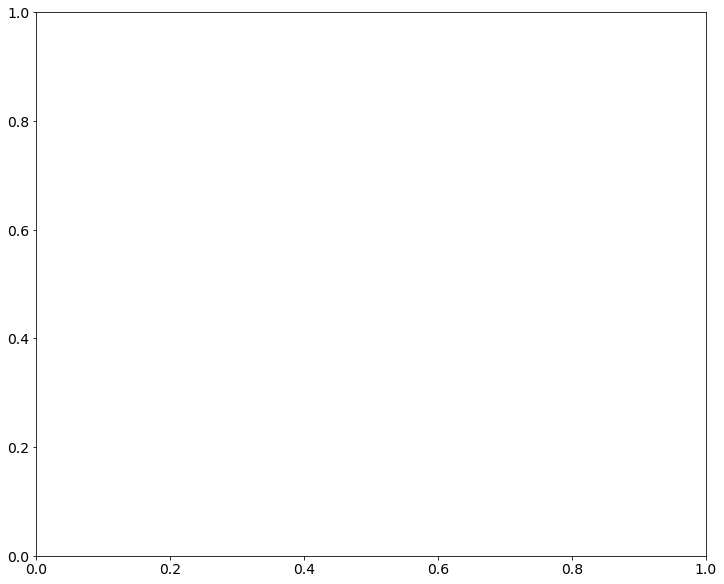

In [241]:
fig, ax = plt.subplots(1, 1, figsize = (12, 10))
ax.plot(ccp_alphas, impurities)

In [227]:
ccp_alphas = ccp_alphas[:4]

In [242]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 10557 with ccp_alpha: 9.78638448224817e-06


In [243]:
len(clfs)

4

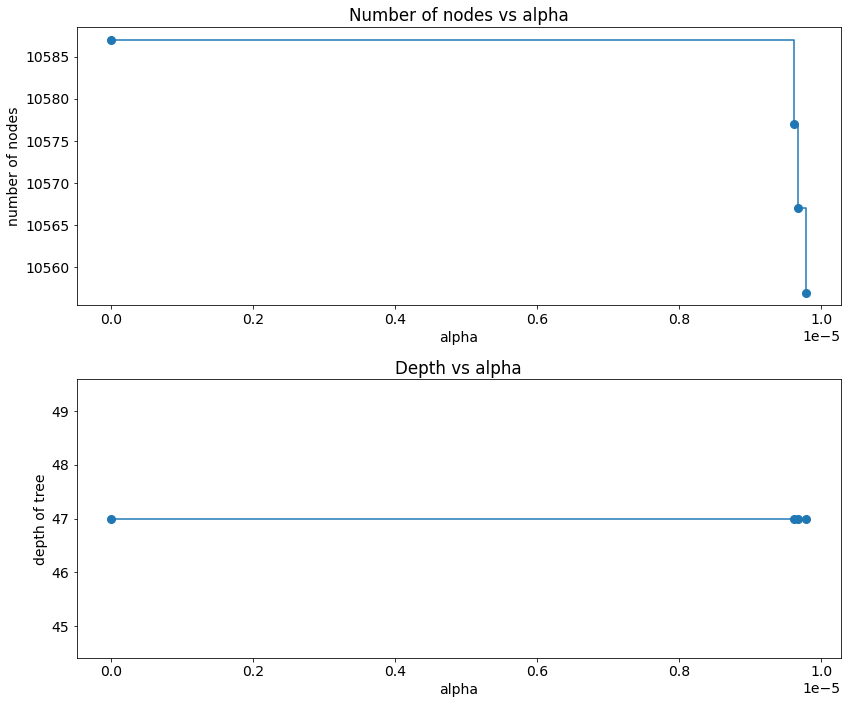

In [244]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize = (12, 10))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

### Do a  randomized search for the hyperparameter search

In [245]:
param_distribs = {
        'min_samples_split': randint(low=1, high=200),    
        'max_depth': randint(low=1, high=20),
    'ccp_alpha': ccp_alphas#np.linspace(0.0, 1.0, 10)
    }

# Number of random searches
n_iter_search = 100

# Cross validation
cv = 5

# Scoring
scoring='roc_auc'

clf_tree = DecisionTreeClassifier(random_state=42)

rnd_search = RandomizedSearchCV(clf_tree, param_distributions=param_distribs,
                                n_iter=n_iter_search, cv=cv, scoring=scoring, 
                                random_state=1)

random_search_tree = rnd_search.fit(X_train, y_train)

In [246]:
bank_data.report_randomized_search(random_search_tree.cv_results_, 2)

Model with rank: 1
Mean validation score: 0.772 (std: 0.007)
Parameters: {'ccp_alpha': 0.0, 'max_depth': 16, 'min_samples_split': 159}

Model with rank: 2
Mean validation score: 0.771 (std: 0.006)
Parameters: {'ccp_alpha': 9.78638448224817e-06, 'max_depth': 15, 'min_samples_split': 189}



In [247]:
random_search_tree.best_estimator_

DecisionTreeClassifier(max_depth=16, min_samples_split=159, random_state=42)

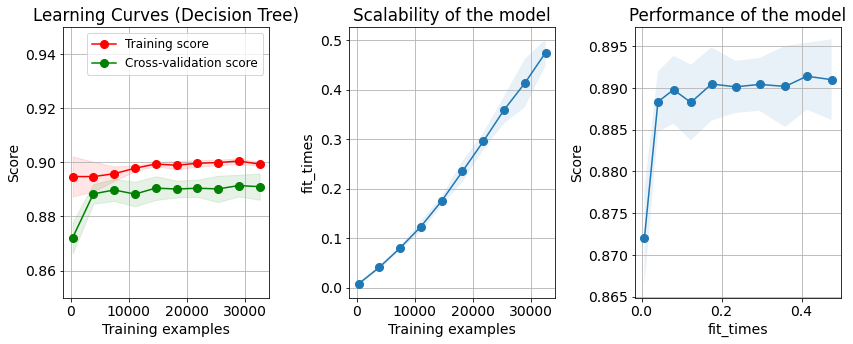

In [262]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

#cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

cv = KFold(n_splits=5)

estimator = random_search_tree.best_estimator_

train_sizes=np.linspace(0.01, 1.0, 10)

scoring = 'accuracy'

title = "Learning Curves (Decision Tree)"
bank_data.plot_learning_curve(
    estimator, title, X_train, y_train, axes=axes, ylim=(0.85, 0.95), cv=cv, n_jobs=4, train_sizes = train_sizes,
    scoring = scoring
)

fig.tight_layout()

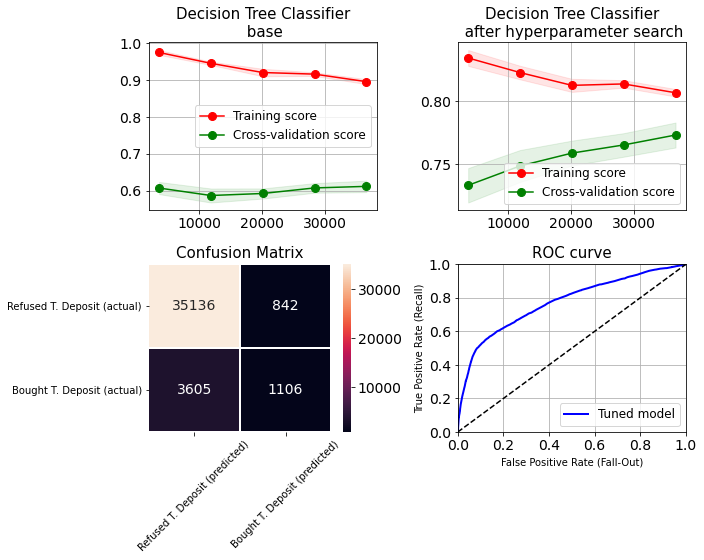

In [277]:
figure = plt.figure(figsize = (10, 8))

estimator_base = DecisionTreeClassifier(max_depth = 20)

cv = 10

train_sizes=np.linspace(0.1, 1.0, 5)

scoring = 'roc_auc'

figure = bank_data.plot_ml_plots(estimator_base = estimator_base, 
                       estimator_tuned = random_search_tree.best_estimator_, 
                       mlAlgorithm = 'Decision Tree Classifier',
                       X = X_train,
                       y = y_train,
                       figure = figure,
                       cv = cv,
                       train_sizes = train_sizes,
                       scoring = scoring)

### Testing implementation of Tree Pruning 

### Try out the pruning class I implemented

In [440]:
iris = load_iris()
X_iris, y_iris = iris.data, iris.target
# Convert iring to a binary classification problem by setting two clases:
y_iris = [1 if y==1 else 0 for y in y_iris]

X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=0.33, random_state=42)



[Text(362.70000000000005, 504.7714285714286, 'X[3] <= 0.8\ngini = 0.455\nsamples = 100\nvalue = [65, 35]'),
 Text(306.90000000000003, 427.11428571428576, 'gini = 0.0\nsamples = 31\nvalue = [31, 0]'),
 Text(418.50000000000006, 427.11428571428576, 'X[3] <= 1.75\ngini = 0.5\nsamples = 69\nvalue = [34, 35]'),
 Text(279.0, 349.4571428571429, 'X[2] <= 5.35\ngini = 0.188\nsamples = 38\nvalue = [4, 34]'),
 Text(223.20000000000002, 271.8, 'X[3] <= 1.65\ngini = 0.105\nsamples = 36\nvalue = [2, 34]'),
 Text(111.60000000000001, 194.14285714285717, 'X[2] <= 4.95\ngini = 0.057\nsamples = 34\nvalue = [1, 33]'),
 Text(55.800000000000004, 116.48571428571432, 'gini = 0.0\nsamples = 32\nvalue = [0, 32]'),
 Text(167.4, 116.48571428571432, 'X[2] <= 5.05\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(111.60000000000001, 38.82857142857142, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(223.20000000000002, 38.82857142857142, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(334.8, 194.14285714285717, 'X

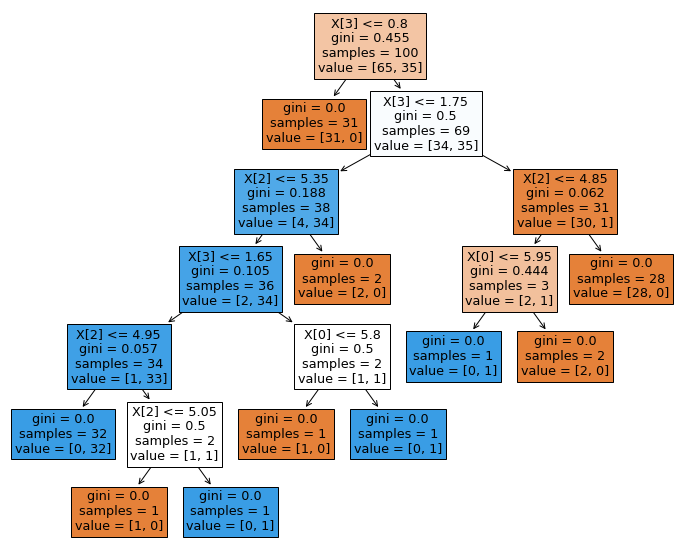

In [449]:
clf = bank_data.PrunedTree(pruneLevel = 0)
clf = clf.fit(X_train_iris, y_train_iris)
fig, ax = plt.subplots(1, 1, figsize = (12, 10))
tree.plot_tree(clf, filled=True, ax = ax)

[Text(365.23636363636365, 504.7714285714286, 'X[3] <= 0.8\ngini = 0.455\nsamples = 100\nvalue = [65, 35]'),
 Text(304.3636363636364, 427.11428571428576, 'gini = 0.0\nsamples = 31\nvalue = [31, 0]'),
 Text(426.1090909090909, 427.11428571428576, 'X[3] <= 1.75\ngini = 0.5\nsamples = 69\nvalue = [34, 35]'),
 Text(304.3636363636364, 349.4571428571429, 'X[2] <= 5.35\ngini = 0.188\nsamples = 38\nvalue = [4, 34]'),
 Text(243.4909090909091, 271.8, 'X[0] <= 4.95\ngini = 0.105\nsamples = 36\nvalue = [2, 34]'),
 Text(121.74545454545455, 194.14285714285717, 'X[1] <= 2.45\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(60.872727272727275, 116.48571428571432, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(182.61818181818182, 116.48571428571432, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(365.23636363636365, 194.14285714285717, 'X[2] <= 4.95\ngini = 0.057\nsamples = 34\nvalue = [1, 33]'),
 Text(304.3636363636364, 116.48571428571432, 'gini = 0.0\nsamples = 31\nvalue = [0, 31]'),
 Text(426.10

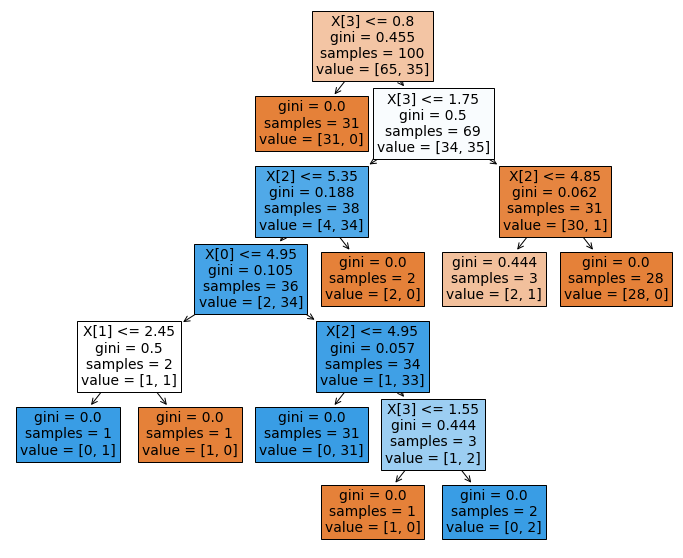

In [450]:
clf = bank_data.PrunedTree(pruneLevel = 1)
clf = clf.fit(X_train_iris, y_train_iris)
fig, ax = plt.subplots(1, 1, figsize = (12, 10))
tree.plot_tree(clf, filled=True, ax = ax)

[Text(372.0, 504.7714285714286, 'X[3] <= 0.8\ngini = 0.455\nsamples = 100\nvalue = [65, 35]'),
 Text(297.6, 427.11428571428576, 'gini = 0.0\nsamples = 31\nvalue = [31, 0]'),
 Text(446.40000000000003, 427.11428571428576, 'X[3] <= 1.75\ngini = 0.5\nsamples = 69\nvalue = [34, 35]'),
 Text(372.0, 349.4571428571429, 'X[2] <= 5.35\ngini = 0.188\nsamples = 38\nvalue = [4, 34]'),
 Text(297.6, 271.8, 'X[0] <= 4.95\ngini = 0.105\nsamples = 36\nvalue = [2, 34]'),
 Text(148.8, 194.14285714285717, 'X[3] <= 1.35\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(74.4, 116.48571428571432, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(223.20000000000002, 116.48571428571432, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(446.40000000000003, 194.14285714285717, 'X[2] <= 4.95\ngini = 0.057\nsamples = 34\nvalue = [1, 33]'),
 Text(372.0, 116.48571428571432, 'gini = 0.0\nsamples = 31\nvalue = [0, 31]'),
 Text(520.8000000000001, 116.48571428571432, 'X[3] <= 1.55\ngini = 0.444\nsamples = 3\nvalue = [1, 

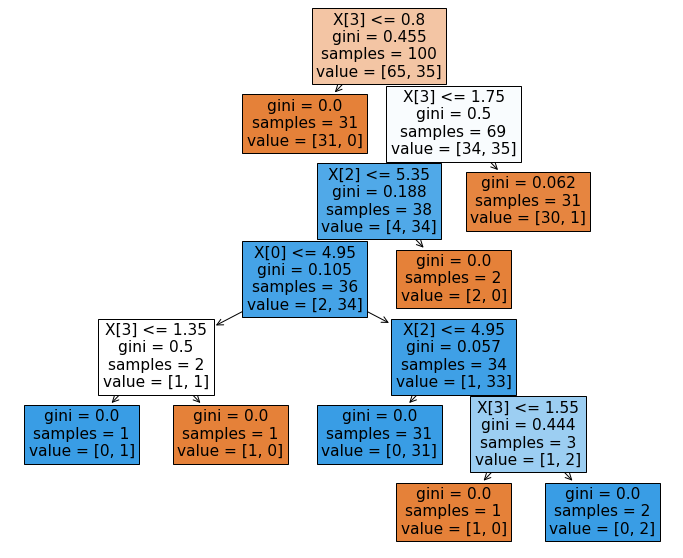

In [451]:
clf = bank_data.PrunedTree(pruneLevel = 2)
clf = clf.fit(X_train_iris, y_train_iris)
fig, ax = plt.subplots(1, 1, figsize = (12, 10))
tree.plot_tree(clf, filled=True, ax = ax)

In [452]:
a = [1, 2, 3, 4]

In [453]:
a[:20]

[1, 2, 3, 4]

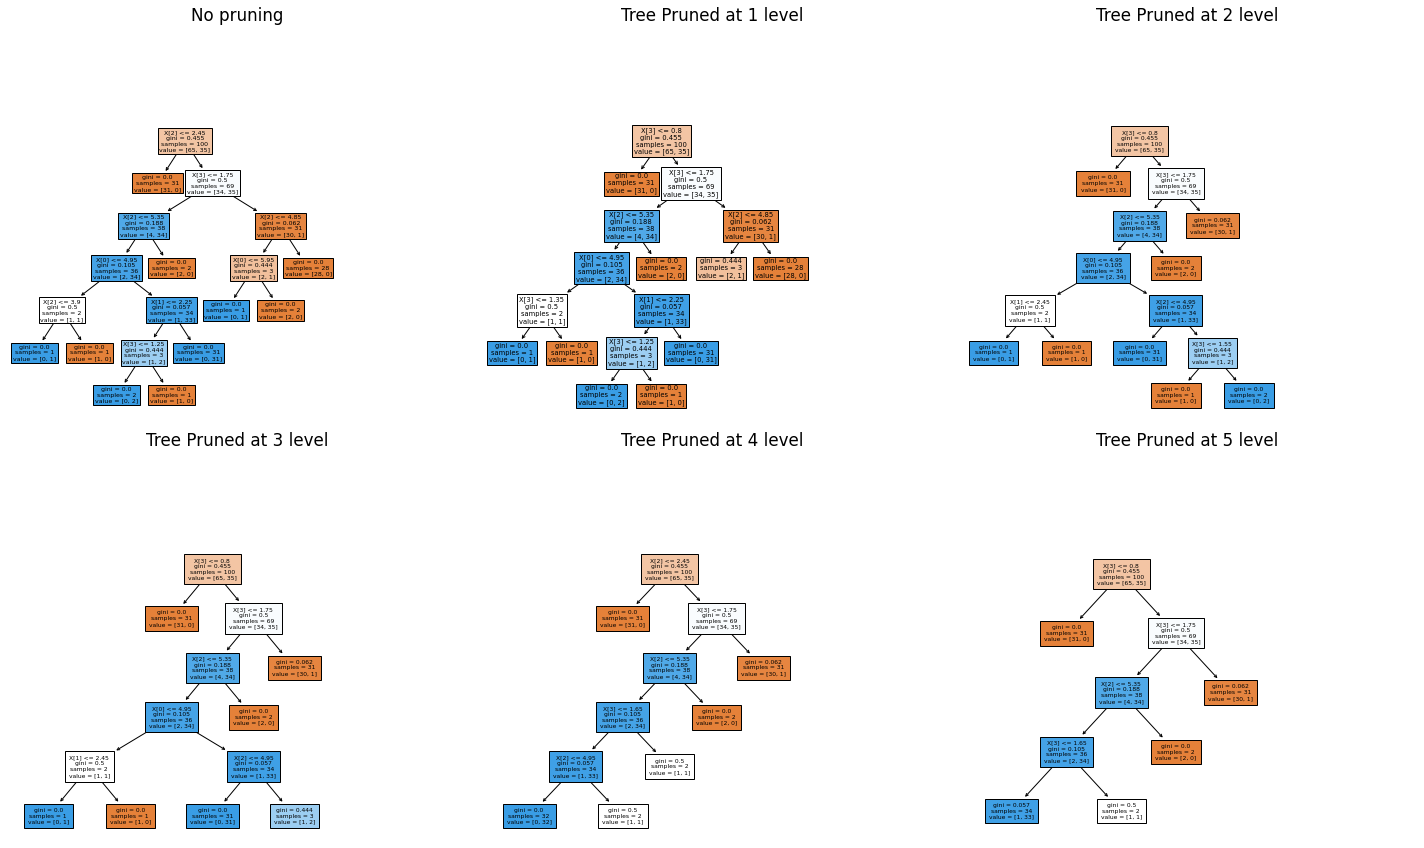

In [480]:
pruneLevels = [None, 1, 2, 3, 4, 5]
fig = plt.figure(figsize = (20, 12))

for idx, pruneLevel in enumerate(pruneLevels):
    
    clf = bank_data.PrunedTree(pruneLevel = pruneLevel)
    clf = clf.fit(X_train_iris, y_train_iris)
    
    ax = fig.add_subplot(2, 3, idx+1)    
    fontsize = 6 if idx in [2, 3,4,5] else None
    tree.plot_tree(clf, filled=True, ax = ax, fontsize = fontsize)
            
    if pruneLevel is None:
        ax.set_title(f"No pruning")
    else:              
        ax.set_title(f"Tree Pruned at {pruneLevel} level")
    
fig.tight_layout()
fig.savefig(os.path.join(OUTFIGURES, "pruning_tree.png"))

### Feed this into a random search CV

### Do a  randomized search for the hyperparameter search

In [491]:
param_distribs = {
        'min_samples_split': randint(low=1, high=200),    
            'max_depth': randint(low=1, high=20),
        'pruneLevel': [None] + list(range(20)),
    }

# Number of random searches
n_iter_search = 100

# Cross validation
cv = 10

# Scoring
scoring='roc_auc'

clf_tree = bank_data.PrunedTree(random_state=1)

rnd_search = RandomizedSearchCV(clf_tree, param_distributions=param_distribs,
                                n_iter=n_iter_search, cv=cv, scoring=scoring, 
                                random_state=1)

random_search_tree = rnd_search.fit(X_train, y_train)

In [492]:
bank_data.report_randomized_search(random_search_tree.cv_results_, 2)

Model with rank: 1
Mean validation score: 0.775 (std: 0.010)
Parameters: {'max_depth': 15, 'min_samples_split': 192, 'pruneLevel': 13}

Model with rank: 2
Mean validation score: 0.775 (std: 0.010)
Parameters: {'max_depth': 15, 'min_samples_split': 189, 'pruneLevel': 18}



In [493]:
random_search_tree.best_estimator_

PrunedTree(max_depth=15, min_samples_split=192, pruneLevel=13, random_state=1)

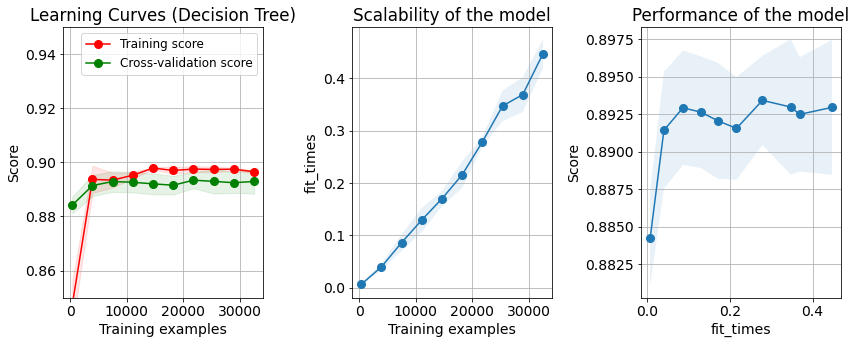

In [494]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

#cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

cv = KFold(n_splits=5)

estimator = random_search_tree.best_estimator_

train_sizes=np.linspace(0.01, 1.0, 10)

scoring = 'accuracy'

title = "Learning Curves (Decision Tree)"
bank_data.plot_learning_curve(
    estimator, title, X_train, y_train, axes=axes, ylim=(0.85, 0.95), cv=cv, n_jobs=4, train_sizes = train_sizes,
    scoring = scoring
)

fig.tight_layout()

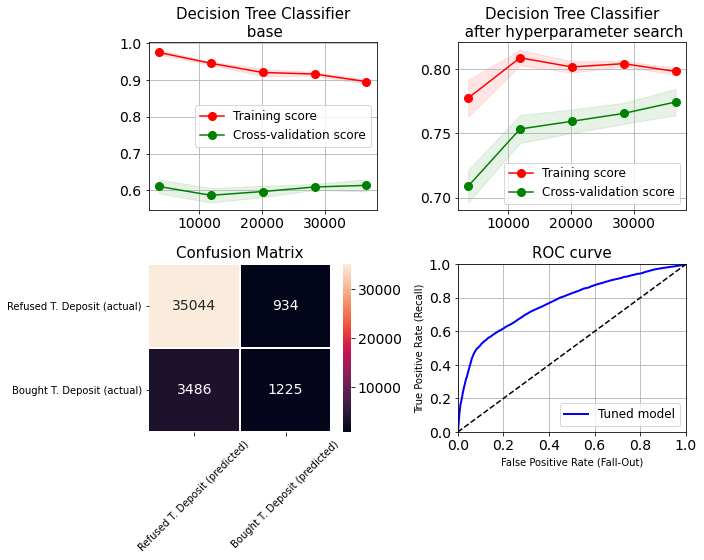

In [495]:
figure = plt.figure(figsize = (10, 8))

estimator_base = DecisionTreeClassifier(max_depth = 20)

cv = 10

train_sizes=np.linspace(0.1, 1.0, 5)

scoring = 'roc_auc'

figure = bank_data.plot_ml_plots(estimator_base = estimator_base, 
                       estimator_tuned = random_search_tree.best_estimator_, 
                       mlAlgorithm = 'Decision Tree Classifier',
                       X = X_train,
                       y = y_train,
                       figure = figure,
                       cv = cv,
                       train_sizes = train_sizes,
                       scoring = scoring)

### Do a  Grid search for the hyperparameter search

In [496]:
param_distribs = {
        'min_samples_split': [5, 10, 20, 50, 100, 150, 200],    
        'max_depth': [1, 2, 3, 5, 8, 10, 15, 20],
        'pruneLevel': [None, 1, 2, 4, 5, 7, 10, 15, 20, 25],
    }

# Cross validation
cv = 10

# Scoring
scoring='roc_auc'

clf_tree = bank_data.PrunedTree(random_state=1)

grid_search = GridSearchCV(clf_tree, param_grid=param_distribs,
                                cv=cv, scoring=scoring)

grid_search_tree = grid_search.fit(X_train, y_train)

In [497]:
bank_data.report_randomized_search(grid_search_tree.cv_results_, 2)

Model with rank: 1
Mean validation score: 0.775 (std: 0.010)
Parameters: {'max_depth': 15, 'min_samples_split': 200, 'pruneLevel': 7}

Model with rank: 2
Mean validation score: 0.775 (std: 0.010)
Parameters: {'max_depth': 15, 'min_samples_split': 200, 'pruneLevel': 25}



In [498]:
grid_search_tree.best_estimator_

PrunedTree(max_depth=15, min_samples_split=200, pruneLevel=7, random_state=1)

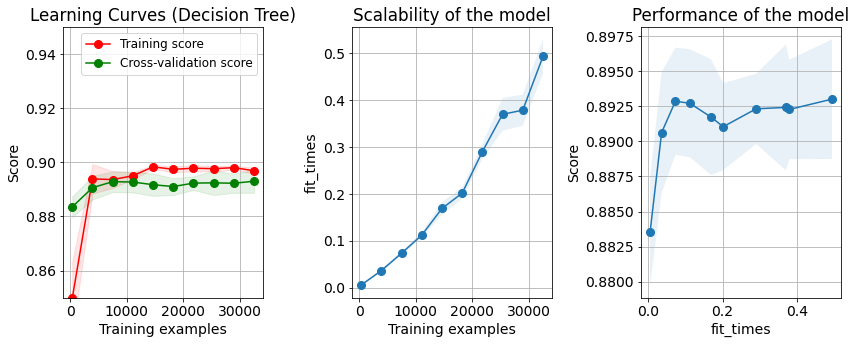

In [499]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

#cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

cv = KFold(n_splits=5)

estimator = grid_search_tree.best_estimator_

train_sizes=np.linspace(0.01, 1.0, 10)

scoring = 'accuracy'

title = "Learning Curves (Decision Tree)"
bank_data.plot_learning_curve(
    estimator, title, X_train, y_train, axes=axes, ylim=(0.85, 0.95), cv=cv, n_jobs=4, train_sizes = train_sizes,
    scoring = scoring
)

fig.tight_layout()

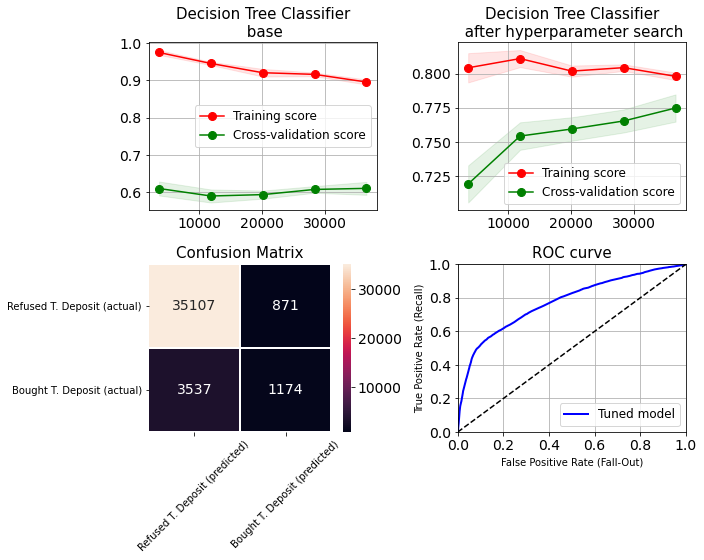

In [500]:
figure = plt.figure(figsize = (10, 8))

estimator_base = DecisionTreeClassifier(max_depth = 20)

cv = 10

train_sizes=np.linspace(0.1, 1.0, 5)

scoring = 'roc_auc'

figure = bank_data.plot_ml_plots(estimator_base = estimator_base, 
                       estimator_tuned = grid_search_tree.best_estimator_, 
                       mlAlgorithm = 'Decision Tree Classifier',
                       X = X_train,
                       y = y_train,
                       figure = figure,
                       cv = cv,
                       train_sizes = train_sizes,
                       scoring = scoring)

### The min_samples_split got very close to 200... probably need to increase it

In [502]:
param_distribs = {
        'min_samples_split': randint(low=1, high=1000),    
            'max_depth': randint(low=1, high=20),
        'pruneLevel': [None] + list(range(20)),
    }

# Number of random searches
n_iter_search = 100

# Cross validation
cv = 10

# Scoring
scoring='roc_auc'

clf_tree = bank_data.PrunedTree(random_state=1)

rnd_search = RandomizedSearchCV(clf_tree, param_distributions=param_distribs,
                                n_iter=n_iter_search, cv=cv, scoring=scoring, 
                                random_state=1)

random_search_tree_2 = rnd_search.fit(X_train, y_train)

bank_data.report_randomized_search(random_search_tree_2.cv_results_, 2)

Model with rank: 1
Mean validation score: 0.776 (std: 0.010)
Parameters: {'max_depth': 17, 'min_samples_split': 733, 'pruneLevel': 18}

Model with rank: 2
Mean validation score: 0.776 (std: 0.010)
Parameters: {'max_depth': 17, 'min_samples_split': 622, 'pruneLevel': 18}



In [506]:
random_search_tree_2.best_estimator_

PrunedTree(max_depth=17, min_samples_split=733, pruneLevel=18, random_state=1)

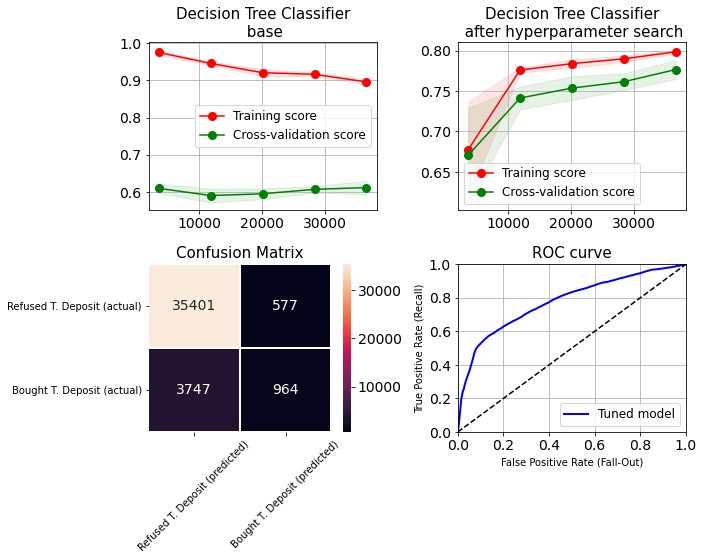

In [507]:
figure = plt.figure(figsize = (10, 8))

estimator_base = DecisionTreeClassifier(max_depth = 20)

cv = 10

train_sizes=np.linspace(0.1, 1.0, 5)

scoring = 'roc_auc'

figure = bank_data.plot_ml_plots(estimator_base = estimator_base, 
                       estimator_tuned = random_search_tree_2.best_estimator_, 
                       mlAlgorithm = 'Decision Tree Classifier',
                       X = X_train,
                       y = y_train,
                       figure = figure,
                       cv = cv,
                       train_sizes = train_sizes,
                       scoring = scoring)

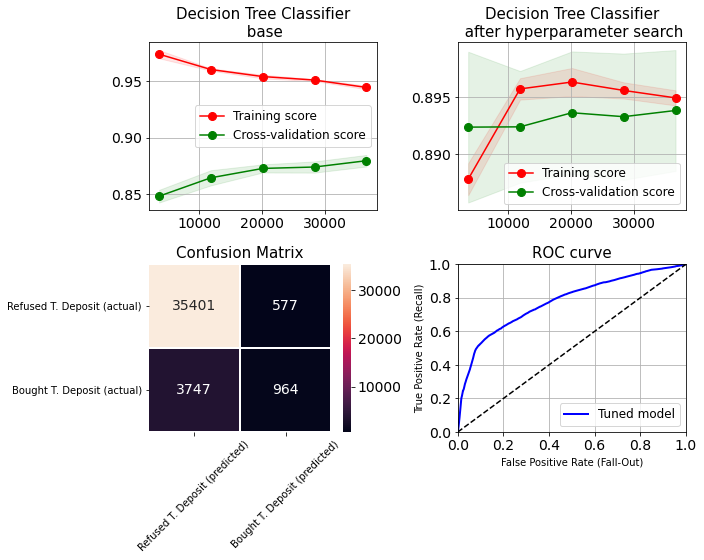

In [509]:
figure = plt.figure(figsize = (10, 8))

estimator_base = DecisionTreeClassifier(max_depth = 20)

cv = 10

train_sizes=np.linspace(0.1, 1.0, 5)

scoring = 'accuracy'

figure = bank_data.plot_ml_plots(estimator_base = estimator_base, 
                       estimator_tuned = random_search_tree_2.best_estimator_, 
                       mlAlgorithm = 'Decision Tree Classifier',
                       X = X_train,
                       y = y_train,
                       figure = figure,
                       cv = cv,
                       train_sizes = train_sizes,
                       scoring = scoring)

## Very good, indeed the min_samples_split needed to go all the way to 733!

What about the others parameters?

In [508]:
param_distribs = {
        'min_samples_split': randint(low=1, high=1000),    
            'max_depth': randint(low=1, high=50),
        'pruneLevel': [None] + list(range(50)),
    }

# Number of random searches
n_iter_search = 100

# Cross validation
cv = 10

# Scoring
scoring='roc_auc'

clf_tree = bank_data.PrunedTree(random_state=1)

rnd_search = RandomizedSearchCV(clf_tree, param_distributions=param_distribs,
                                n_iter=n_iter_search, cv=cv, scoring=scoring, 
                                random_state=1)

random_search_tree_3 = rnd_search.fit(X_train, y_train)

bank_data.report_randomized_search(random_search_tree_3.cv_results_, 2)

Model with rank: 1
Mean validation score: 0.776 (std: 0.008)
Parameters: {'max_depth': 37, 'min_samples_split': 870, 'pruneLevel': 20}

Model with rank: 2
Mean validation score: 0.776 (std: 0.010)
Parameters: {'max_depth': 15, 'min_samples_split': 303, 'pruneLevel': None}



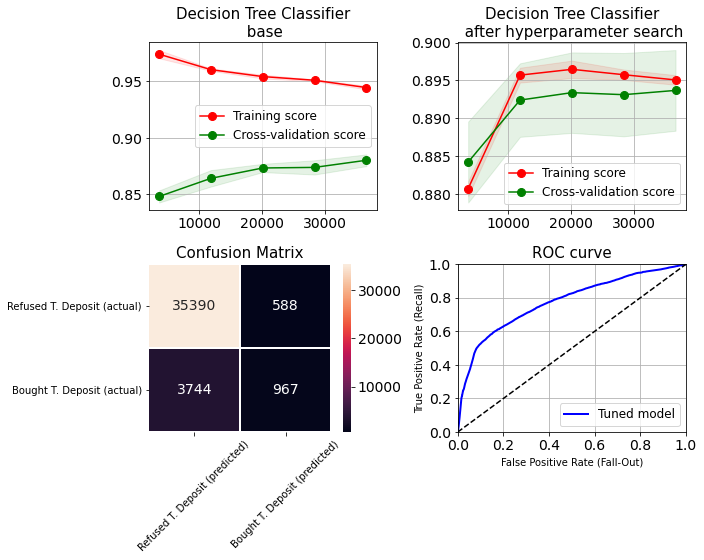

In [510]:
figure = plt.figure(figsize = (10, 8))

estimator_base = DecisionTreeClassifier(max_depth = 20)

cv = 10

train_sizes=np.linspace(0.1, 1.0, 5)

scoring = 'accuracy'

figure = bank_data.plot_ml_plots(estimator_base = estimator_base, 
                       estimator_tuned = random_search_tree_3.best_estimator_, 
                       mlAlgorithm = 'Decision Tree Classifier',
                       X = X_train,
                       y = y_train,
                       figure = figure,
                       cv = cv,
                       train_sizes = train_sizes,
                       scoring = scoring)

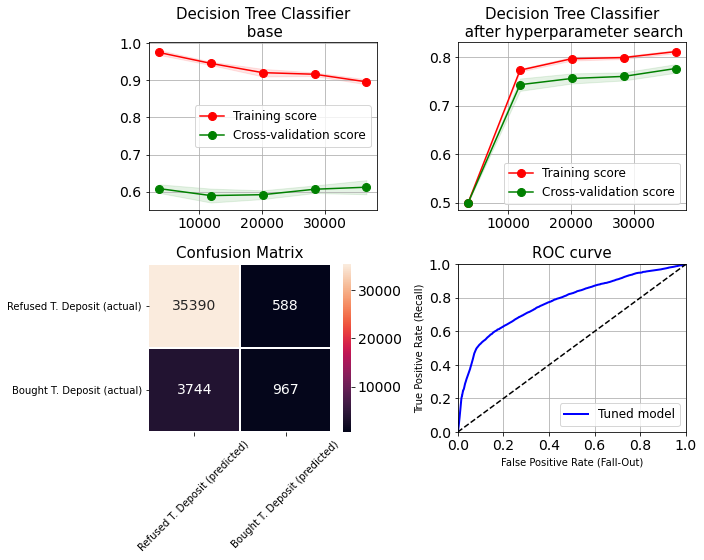

In [511]:
figure = plt.figure(figsize = (10, 8))

estimator_base = DecisionTreeClassifier(max_depth = 20)

cv = 10

train_sizes=np.linspace(0.1, 1.0, 5)

scoring = 'roc_auc'

figure = bank_data.plot_ml_plots(estimator_base = estimator_base, 
                       estimator_tuned = random_search_tree_3.best_estimator_, 
                       mlAlgorithm = 'Decision Tree Classifier',
                       X = X_train,
                       y = y_train,
                       figure = figure,
                       cv = cv,
                       train_sizes = train_sizes,
                       scoring = scoring)

In [513]:
figure.savefig(os.path.join(OUTFIGURES, "tuned_tree_bank_data.png"))

### Plot the learning curve and validation curves

In [514]:
random_search_tree_3.best_estimator_

PrunedTree(max_depth=37, min_samples_split=870, pruneLevel=20, random_state=1)

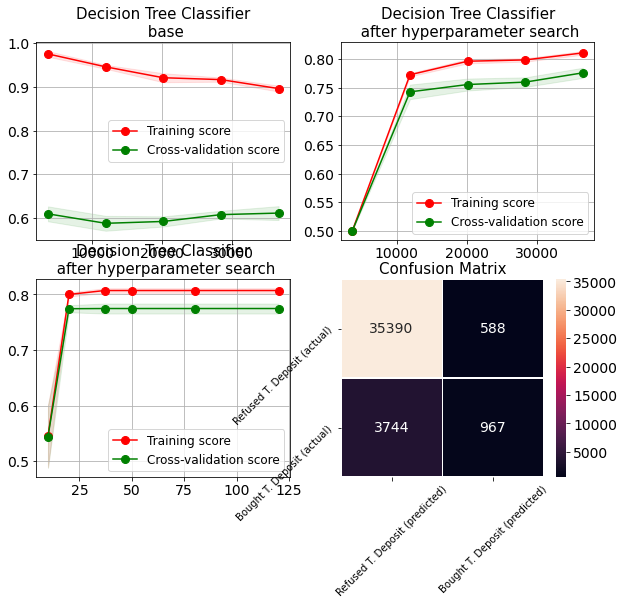

In [525]:
figure = plt.figure(figsize = (10, 8))

estimator_base = DecisionTreeClassifier(max_depth = 20)

cv = 10

train_sizes=np.linspace(0.1, 1.0, 5)

scoring = 'roc_auc'

figure = bank_data.plot_ml_plots_2(estimator_base = estimator_base, 
                       estimator_tuned = random_search_tree_3.best_estimator_, 
                       mlAlgorithm = 'Decision Tree Classifier',
                       X = X_train,
                       y = y_train,
                       param_name = 'max_depth',
                       param_range = [10, 20, 37, 50, 80, 120],            
                       figure = figure,
                       cv = cv,
                       train_sizes = train_sizes,
                       scoring = scoring)

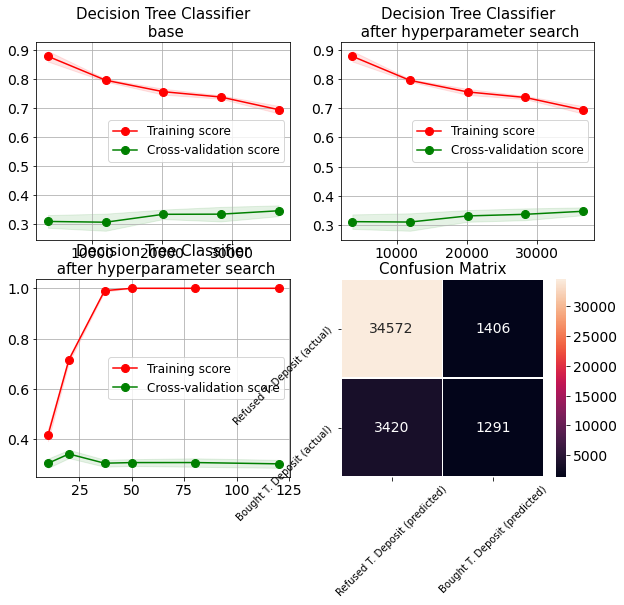

In [526]:
figure = plt.figure(figsize = (10, 8))

estimator_base = DecisionTreeClassifier(max_depth = 20)

cv = 10

train_sizes=np.linspace(0.1, 1.0, 5)

scoring = 'f1'

figure = bank_data.plot_ml_plots_2(estimator_base = estimator_base, 
                       estimator_tuned = estimator_base, 
                       mlAlgorithm = 'Decision Tree Classifier',
                       X = X_train,
                       y = y_train,
                       param_name = 'max_depth',
                       param_range = [10, 20, 37, 50, 80, 120],            
                       figure = figure,
                       cv = cv,
                       train_sizes = train_sizes,
                       scoring = scoring)

## Base algorithms

Run learning curve, validation curve and running time across a set of base algorithms

In [838]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

In [839]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.naive_bayes import GaussianNB

In [856]:
X_train.shape

(40689, 50)

In [857]:
# Parameters 
#train_sizes = np.linspace(0.2, 1.0, 5)
train_sizes = [1000, 3000, 4500, 6000, 10000]
n_jobs      = -1
scoring     = 'roc_auc'

### Decision Tree

In [858]:
results = {}

In [859]:
cv          = 10

algoData = (bank_data.PrunedTree(), "Decision tree - Max Depth", 'max_depth', [10, 20, 30, 40, 50, 60])

baseAlgo, algoName, param_name, param_range = algoData

learning_curve_data = learning_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )

validation_curve_data = validation_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    param_name=param_name,
                                    param_range=param_range,
                                    scoring=scoring,
                                    n_jobs=n_jobs,
                                )

results[algoName] = {'learning': learning_curve_data, 'validation': validation_curve_data,
                    'algoData': algoData}

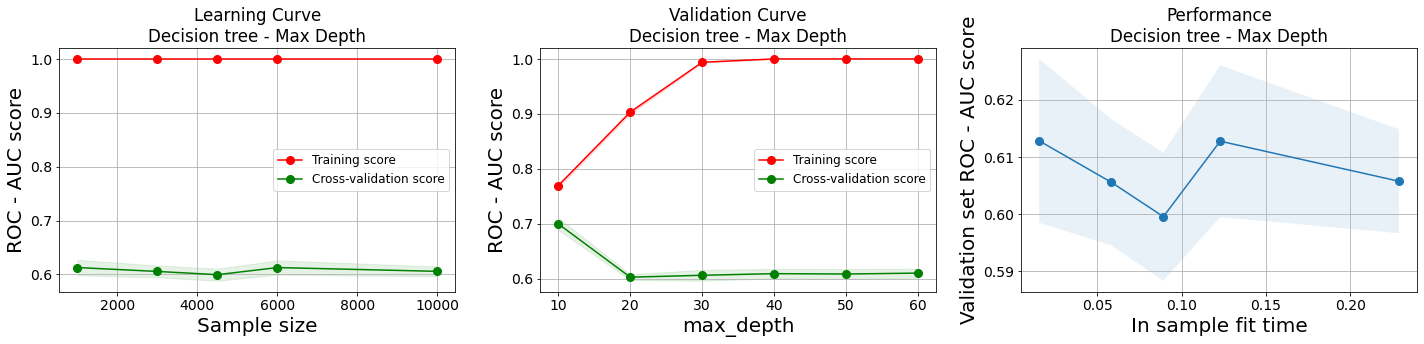

In [965]:
algoName = "Decision tree - Max Depth"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 3, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title, ylabel = 'ROC - AUC score')

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 3, 2)
param_range = algoData[3]
train_scores, test_scores = results[algoName]['validation']

param_name = algoData[2]
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = param_name, ylabel = 'ROC - AUC score')

# Score vs Fit-Time
title = 'Performance\n' + algoName
ax = figure.add_subplot(1, 3, 3)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotScoreVsFitTime(fit_times, test_scores, ax, title, ylabel = 'Validation set ROC - AUC score')
figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "tree_val_curves_max_width.png")))

### Decision tree - change the prune level

In [861]:
cv          = 10

algoData = (bank_data.PrunedTree(pruneLevel = 10), "Decision tree - Prunning", 'pruneLevel', [10, 100, 200, 300, 400, 500, 600, 700, 800])

baseAlgo, algoName, param_name, param_range = algoData

learning_curve_data = learning_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )

validation_curve_data = validation_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    param_name=param_name,
                                    param_range=param_range,
                                    scoring=scoring,
                                    n_jobs=n_jobs,
                                )

results[algoName] = {'learning': learning_curve_data, 'validation': validation_curve_data,
                    'algoData': algoData}

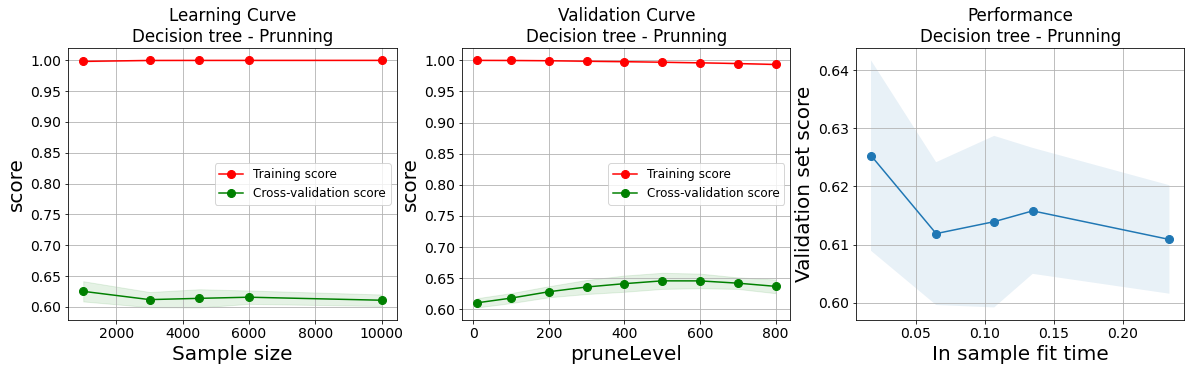

In [862]:
algoName = "Decision tree - Prunning"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 3, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title)

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 3, 2)
param_range = algoData[3]
train_scores, test_scores = results[algoName]['validation']

param_name = algoData[2]
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = param_name)

# Score vs Fit-Time
title = 'Performance\n' + algoName
ax = figure.add_subplot(1, 3, 3)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotScoreVsFitTime(fit_times, test_scores, ax, title)


#### Combine the max depth with the prune level

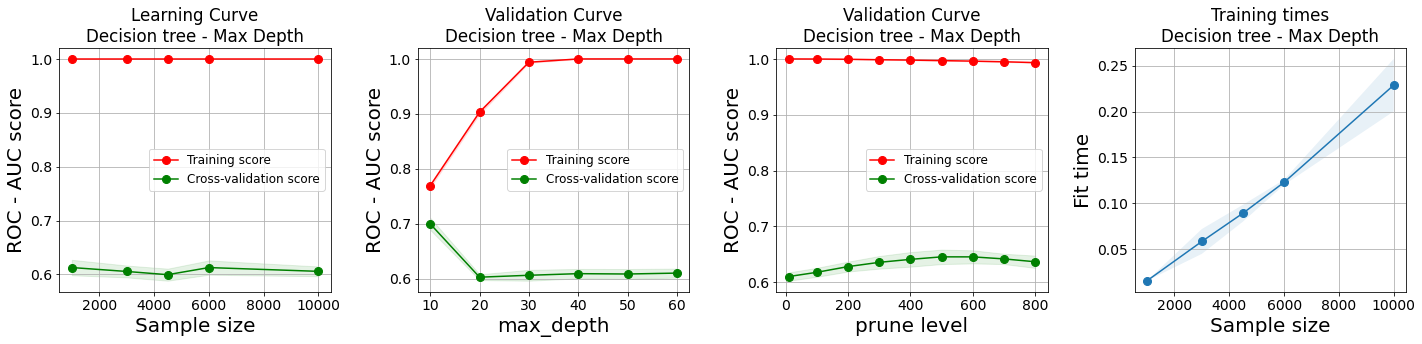

In [966]:
algoName = "Decision tree - Max Depth"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 4, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title, ylabel = 'ROC - AUC score')

# Validation Curve - max depth
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 4, 2)
param_range = algoData[3]
train_scores, test_scores = results[algoName]['validation']

param_name = algoData[2]
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = param_name, ylabel = 'ROC - AUC score')


# Validation Curve - prune
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 4, 3)
param_range = results["Decision tree - Prunning"]['algoData'][3]
train_scores, test_scores = results["Decision tree - Prunning"]['validation']

param_name = algoData[2]
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = "prune level", ylabel = 'ROC - AUC score')



# Score vs Fit-Time
#title = 'Performance\n' + algoName
#ax = figure.add_subplot(1, 4, 4)
#param_range = algoData[3]
#train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
#plots.plotScoreVsFitTime(fit_times, test_scores, ax, title, ylabel = 'Validation set ROC - AUC score')

#figure.tight_layout()
#figure.savefig(os.path.join(os.path.join(OUTFIGURES, "tree_val_curves_max_width_prune_level.png")))


# Score vs Fit-Time
title = 'Training times\n' + algoName
ax = figure.add_subplot(1, 4, 4)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotSampleSizeVsFitTime(train_sizes, fit_times, ax, title)

figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "tree_val_curves_max_width_prune_level.png")))




### Neural Network - depth

In [864]:
cv = 4
algoData = (MLPClassifier(hidden_layer_sizes = (10,)), "Neural Network - depth", 'hidden_layer_sizes', [(10,),                                                                                                         
                                                                                                        (10, 10, 10), 
                                                                                                        (10, 10, 10, 10, 10),
                                                                                                        (10, 10, 10, 10, 10, 10, 10),
                                                                                                        (10, 10, 10, 10, 10, 10, 10, 10, 10, 10),
                                                                                                        (10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10)
                                                                                                       ])

baseAlgo, algoName, param_name, param_range = algoData

learning_curve_data = learning_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )

validation_curve_data = validation_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    param_name=param_name,
                                    param_range=param_range,
                                    scoring=scoring,
                                    n_jobs=n_jobs,
                                )

results[algoName] = {'learning': learning_curve_data, 'validation': validation_curve_data,
                    'algoData': algoData}

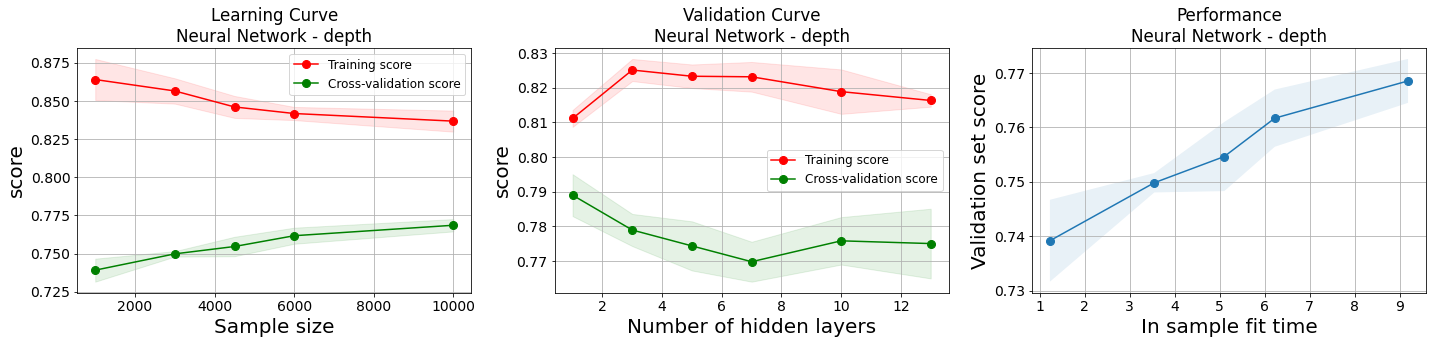

In [967]:
algoName = "Neural Network - depth"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 3, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title)

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 3, 2)
param_range = [len(layer) for layer in algoData[3]]
train_scores, test_scores = results[algoName]['validation']
xlabel = "Number of hidden layers"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel)

# Score vs Fit-Time
title = 'Performance\n' + algoName
ax = figure.add_subplot(1, 3, 3)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotScoreVsFitTime(fit_times, test_scores, ax, title)

figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "neuralnets_val_curves_depth.png")))

### Neural Network - width

In [866]:
cv = 4
algoData = (MLPClassifier(hidden_layer_sizes = (10,)), "Neural Network - width", 'hidden_layer_sizes', [(10,),                                                                                                                                                                                                                 
                                                                                                        (100, ),
                                                                                                        (200, ),
                                                                                                        (500, ),
                                                                                                       (1000, )])



baseAlgo, algoName, param_name, param_range = algoData

learning_curve_data = learning_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )

validation_curve_data = validation_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    param_name=param_name,
                                    param_range=param_range,
                                    scoring=scoring,
                                    n_jobs=n_jobs,
                                )

results[algoName] = {'learning': learning_curve_data, 'validation': validation_curve_data,
                    'algoData': algoData}

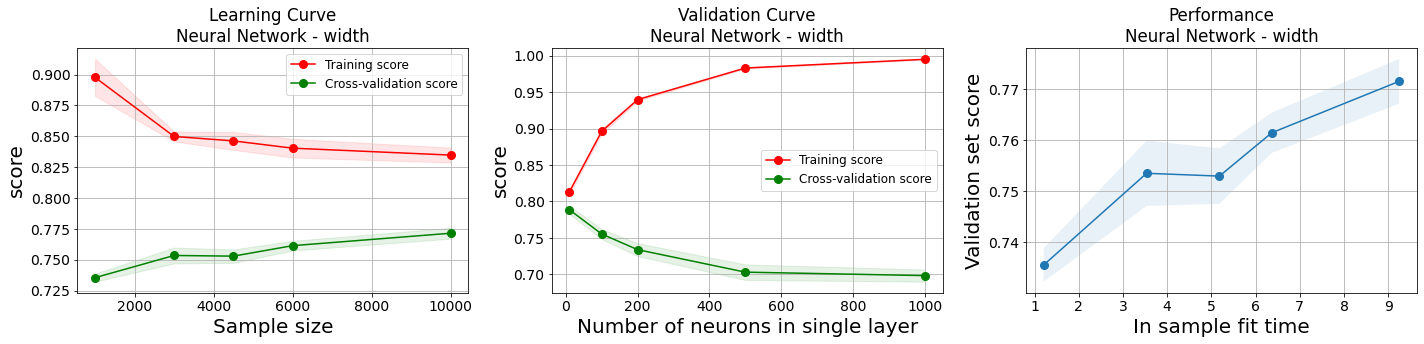

In [968]:
algoName = "Neural Network - width"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 3, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title)

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 3, 2)
param_range = [layer[0] for layer in algoData[3]]
train_scores, test_scores = results[algoName]['validation']
xlabel = "Number of neurons in single layer"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel)

# Score vs Fit-Time
title = 'Performance\n' + algoName
ax = figure.add_subplot(1, 3, 3)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotScoreVsFitTime(fit_times, test_scores, ax, title)

figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "neuralnets_val_curves_width.png")))

#### Combine the depth and with of the Neural net

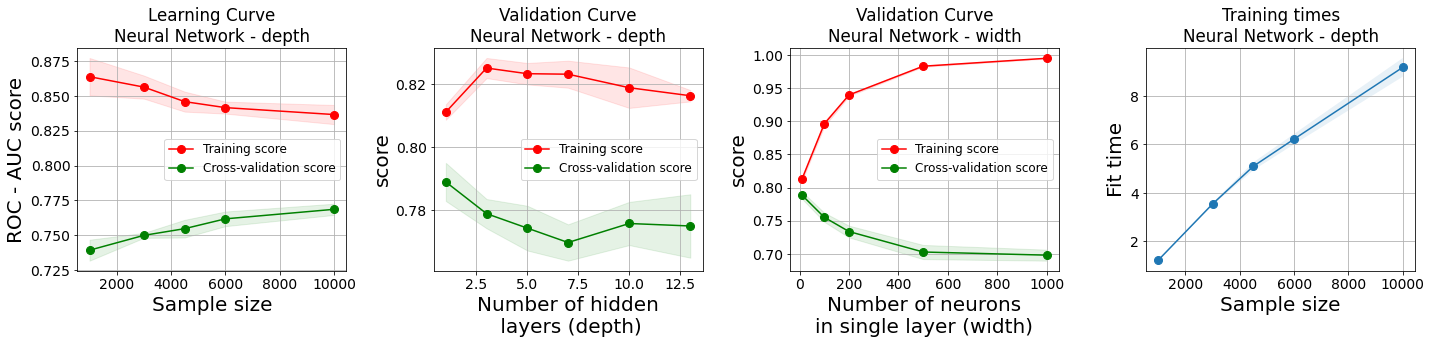

In [969]:
algoName = "Neural Network - depth"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 4, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title, ylabel = 'ROC - AUC score')

# Validation Curve - Depth
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 4, 2)
param_range = [len(layer) for layer in algoData[3]]
train_scores, test_scores = results[algoName]['validation']
xlabel = "Number of hidden\n layers (depth)"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel)


# Validation Curve - Width
title = 'Validation Curve\n' + "Neural Network - width"
ax = figure.add_subplot(1, 4, 3)
param_range = [layer[0] for layer in results["Neural Network - width"]['algoData'][3]]
train_scores, test_scores = results["Neural Network - width"]['validation']
xlabel = "Number of neurons\nin single layer (width)"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel)



# Score vs Fit-Time
#title = 'Performance\n' + algoName
#ax = figure.add_subplot(1, 4, 4)
#param_range = algoData[3]
#train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
#plots.plotScoreVsFitTime(fit_times, test_scores, ax, title, ylabel = 'Validation set\nROC-AUC score')


# Training time
title = 'Training times\n' + algoName
ax = figure.add_subplot(1, 4, 4)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotSampleSizeVsFitTime(train_sizes, fit_times, ax, title)


figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "neuralnets_val_curves_width_depth.png")))

### Neural Network - learning rate

In [975]:
cv = 4
algoData = (MLPClassifier(hidden_layer_sizes = (10,),
                         learning_rate = 'constant'), 
            "Neural Network - Learning rate", 
            'learning_rate_init', [1e-4, 1e-3, 1e-2, 1e-1])



baseAlgo, algoName, param_name, param_range = algoData

learning_curve_data = learning_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )

validation_curve_data = validation_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    param_name=param_name,
                                    param_range=param_range,
                                    scoring=scoring,
                                    n_jobs=n_jobs,
                                )

results[algoName] = {'learning': learning_curve_data, 'validation': validation_curve_data,
                    'algoData': algoData}

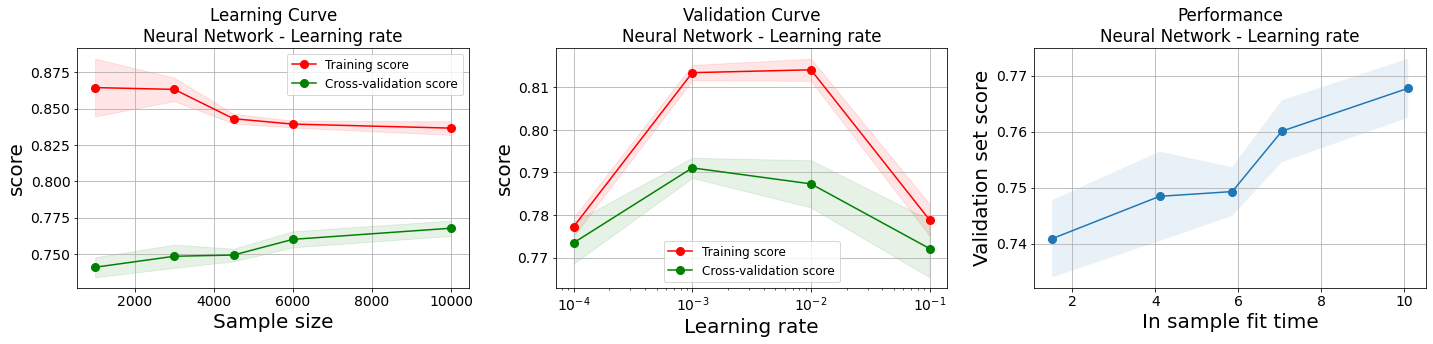

In [979]:
algoName = "Neural Network - Learning rate"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 3, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title)

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 3, 2)
param_range = algoData[3]
train_scores, test_scores = results[algoName]['validation']
xlabel = "Learning rate"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel, xscale = 'log')

# Score vs Fit-Time
title = 'Performance\n' + algoName
ax = figure.add_subplot(1, 3, 3)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotScoreVsFitTime(fit_times, test_scores, ax, title)

figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "neuralnets_val_curves_learning_rate.png")))

### Try a deeper network

In [980]:
cv = 4
algoData = (MLPClassifier(hidden_layer_sizes = (10,10,10),
                         learning_rate = 'constant'), 
            "Neural Network - Learning rate - deep", 
            'learning_rate_init', [1e-4, 1e-3, 1e-2, 1e-1])



baseAlgo, algoName, param_name, param_range = algoData

learning_curve_data = learning_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )

validation_curve_data = validation_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    param_name=param_name,
                                    param_range=param_range,
                                    scoring=scoring,
                                    n_jobs=n_jobs,
                                )

results[algoName] = {'learning': learning_curve_data, 'validation': validation_curve_data,
                    'algoData': algoData}

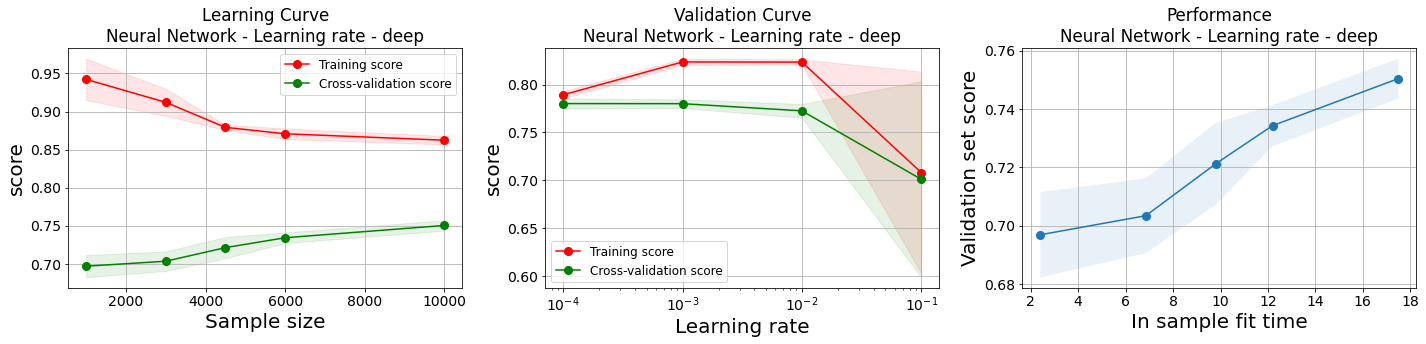

In [981]:
algoName = "Neural Network - Learning rate - deep"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 3, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title)

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 3, 2)
param_range = algoData[3]
train_scores, test_scores = results[algoName]['validation']
xlabel = "Learning rate"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel, xscale = 'log')

# Score vs Fit-Time
title = 'Performance\n' + algoName
ax = figure.add_subplot(1, 3, 3)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotScoreVsFitTime(fit_times, test_scores, ax, title)

figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "neuralnets_val_curves_learning_rate_deeper.png")))

#### Combine the depth, width and learning rate of the Neural net

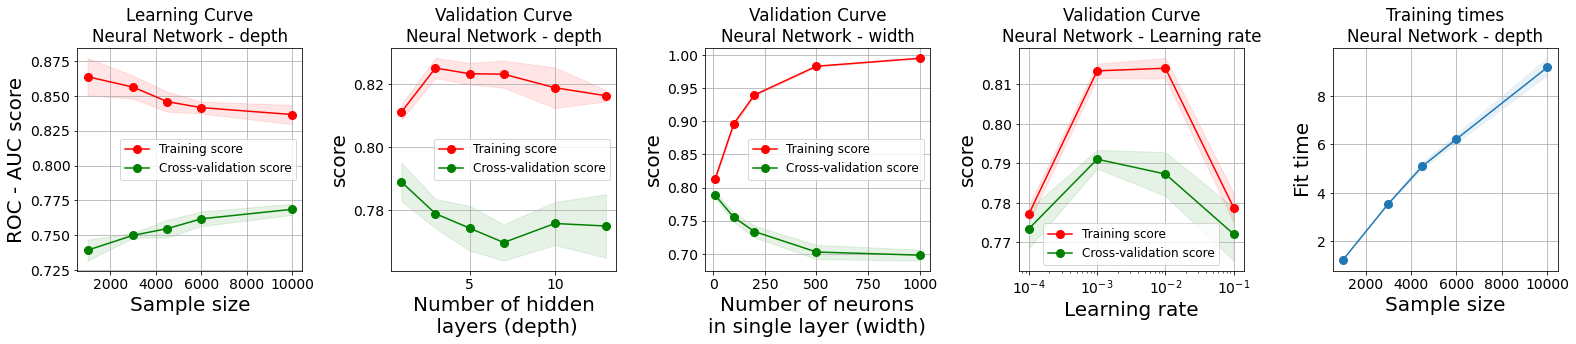

In [986]:
algoName = "Neural Network - depth"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (22, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 5, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title, ylabel = 'ROC - AUC score')

# Validation Curve - Depth
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 5, 2)
param_range = [len(layer) for layer in algoData[3]]
train_scores, test_scores = results[algoName]['validation']
xlabel = "Number of hidden\n layers (depth)"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel)


# Validation Curve - Width
title = 'Validation Curve\n' + "Neural Network - width"
ax = figure.add_subplot(1, 5, 3)
param_range = [layer[0] for layer in results["Neural Network - width"]['algoData'][3]]
train_scores, test_scores = results["Neural Network - width"]['validation']
xlabel = "Number of neurons\nin single layer (width)"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel)


# Learning rate

title = 'Validation Curve\n' + "Neural Network - Learning rate"
ax = figure.add_subplot(1, 5, 4)
param_range = results["Neural Network - Learning rate"]['algoData'][3]
train_scores, test_scores = results["Neural Network - Learning rate"]['validation']
xlabel = "Learning rate"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel, xscale = 'log')


# Training time
title = 'Training times\n' + algoName
ax = figure.add_subplot(1, 5, 5)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotSampleSizeVsFitTime(train_sizes, fit_times, ax, title)


figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "neuralnets_val_curves_width_depth_learning.png")))

### Boosting

In [869]:
cv = 10
algoData = (AdaBoostClassifier(n_estimators = 2), "AdaBoostClassifier", 'n_estimators', [2, 5, 10, 20, 50, 100, 200, 500])

baseAlgo, algoName, param_name, param_range = algoData

learning_curve_data = learning_curve(
                                    baseAlgo,
                                     X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )

validation_curve_data = validation_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    param_name=param_name,
                                    param_range=param_range,
                                    scoring=scoring,
                                    n_jobs=n_jobs,
                                )

results[algoName] = {'learning': learning_curve_data, 'validation': validation_curve_data,
                    'algoData': algoData}

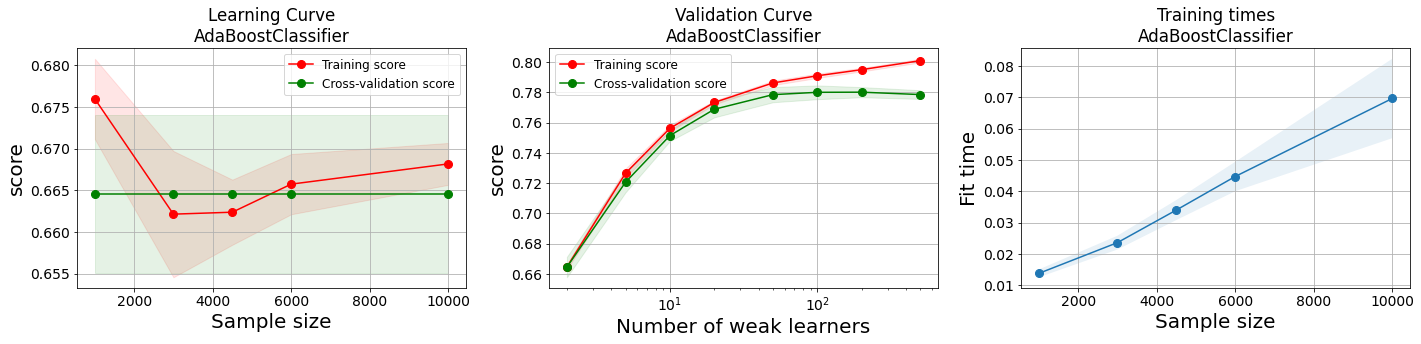

In [970]:
algoName = "AdaBoostClassifier"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 3, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title)

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 3, 2)
param_range = algoData[3]
train_scores, test_scores = results[algoName]['validation']
xlabel = "Number of weak learners"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel, xscale = 'log')

# Score vs Fit-Time
#title = 'Performance\n' + algoName
#ax = figure.add_subplot(1, 3, 3)
#param_range = algoData[3]
#train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
#plots.plotScoreVsFitTime(fit_times, test_scores, ax, title)

# Training time
title = 'Training times\n' + algoName
ax = figure.add_subplot(1, 3, 3)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotSampleSizeVsFitTime(train_sizes, fit_times, ax, title)


figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "bossting_val_curves_numweaklearners.png")))

### SVC - Linear kernel

In [871]:
cv = 4

algoData = (SVC(kernel = 'linear', C = 0.01), "SVC - Linear kernel", 'C', [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 1.5])

baseAlgo, algoName, param_name, param_range = algoData

learning_curve_data = learning_curve(
                                    baseAlgo,
                                     X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )

validation_curve_data = validation_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    param_name=param_name,
                                    param_range=param_range,
                                    scoring=scoring,
                                    n_jobs=n_jobs,
                                )

results[algoName] = {'learning': learning_curve_data, 'validation': validation_curve_data,
                    'algoData': algoData}

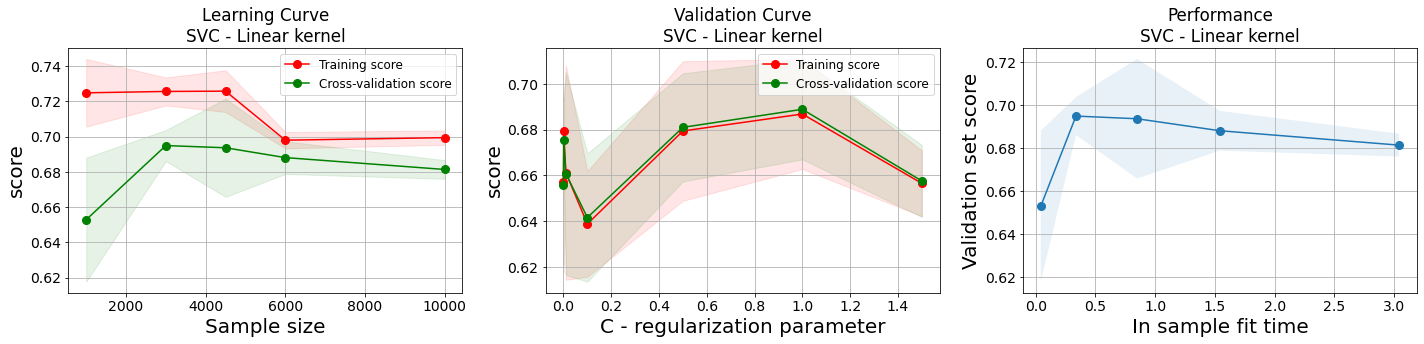

In [971]:
algoName = "SVC - Linear kernel"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 3, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title)

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 3, 2)
param_range = algoData[3]
train_scores, test_scores = results[algoName]['validation']
xlabel = "C - regularization parameter"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel)

# Score vs Fit-Time
title = 'Performance\n' + algoName
ax = figure.add_subplot(1, 3, 3)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotScoreVsFitTime(fit_times, test_scores, ax, title)

figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "svc_val_curves_linear.png")))

### SVC - rbf

In [873]:
cv = 4
algoData = (SVC(kernel = 'rbf', C = 0.01), "SVC - Radial Basis Function", 'C', [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 1.5])

baseAlgo, algoName, param_name, param_range = algoData

learning_curve_data = learning_curve(
                                    baseAlgo,
                                     X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )

validation_curve_data = validation_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    param_name=param_name,
                                    param_range=param_range,
                                    scoring=scoring,
                                    n_jobs=n_jobs,
                                )

results[algoName] = {'learning': learning_curve_data, 'validation': validation_curve_data,
                    'algoData': algoData}

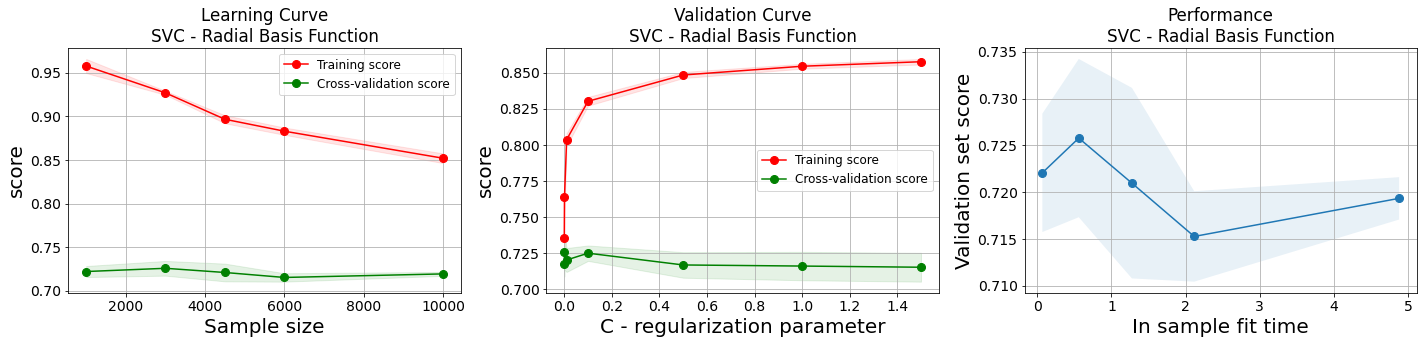

In [972]:
algoName = "SVC - Radial Basis Function"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 3, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title)

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 3, 2)
param_range = algoData[3]
train_scores, test_scores = results[algoName]['validation']
xlabel = "C - regularization parameter"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel)

# Score vs Fit-Time
title = 'Performance\n' + algoName
ax = figure.add_subplot(1, 3, 3)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotScoreVsFitTime(fit_times, test_scores, ax, title)

figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "svc_val_curves_rbf.png")))

#### Combine the different kernels

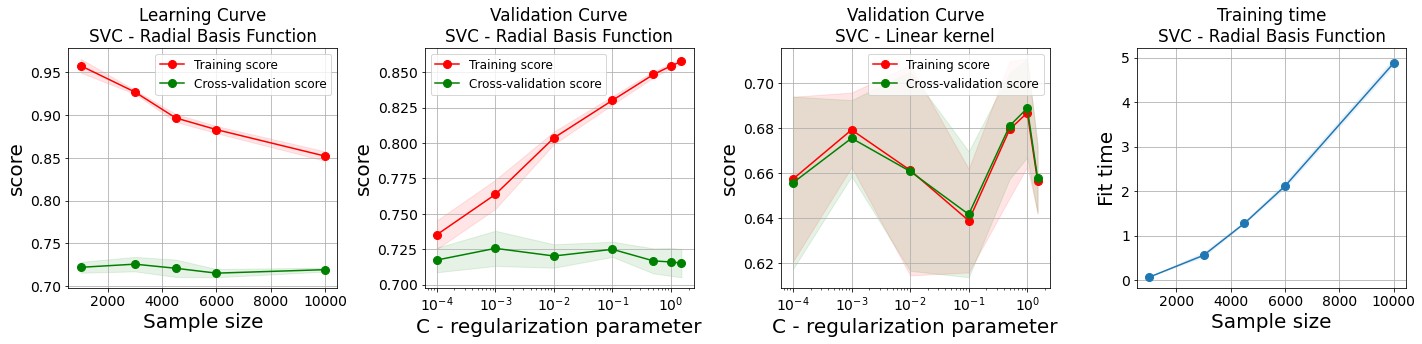

In [973]:
algoName = "SVC - Radial Basis Function"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 4, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title)

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 4, 2)
param_range = algoData[3]
train_scores, test_scores = results[algoName]['validation']
xlabel = "C - regularization parameter"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel, xscale = 'log')

# Validation Curve
title = 'Validation Curve\n' + "SVC - Linear kernel"
ax = figure.add_subplot(1, 4, 3)
param_range = results["SVC - Linear kernel"]['algoData'][3]
train_scores, test_scores = results["SVC - Linear kernel"]['validation']
xlabel = "C - regularization parameter"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel, xscale = 'log')


# Score vs Fit-Time
#title = 'Performance\n' + algoName
#ax = figure.add_subplot(1, 4, 4)
#param_range = algoData[3]
#train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
#plots.plotScoreVsFitTime(fit_times, test_scores, ax, title)

#figure.tight_layout()
#figure.savefig(os.path.join(os.path.join(OUTFIGURES, "svc_val_curves_rbf_linear.png")))

# Sample Size vs Fit-Time
title = 'Training time\n' + algoName
ax = figure.add_subplot(1, 4, 4)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotSampleSizeVsFitTime(train_sizes, fit_times, ax, title)

figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "svc_val_curves_rbf_linear.png")))

### K-NN

In [876]:
cv = 4
algoData = (KNeighborsClassifier(n_neighbors = 20), "K-NN", 'n_neighbors', [1, 5, 10, 20, 40, 50, 80, 100])

baseAlgo, algoName, param_name, param_range = algoData

learning_curve_data = learning_curve(
                                    baseAlgo,
                                     X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )

validation_curve_data = validation_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    param_name=param_name,
                                    param_range=param_range,
                                    scoring=scoring,
                                    n_jobs=n_jobs,
                                )

results[algoName] = {'learning': learning_curve_data, 'validation': validation_curve_data,
                    'algoData': algoData}

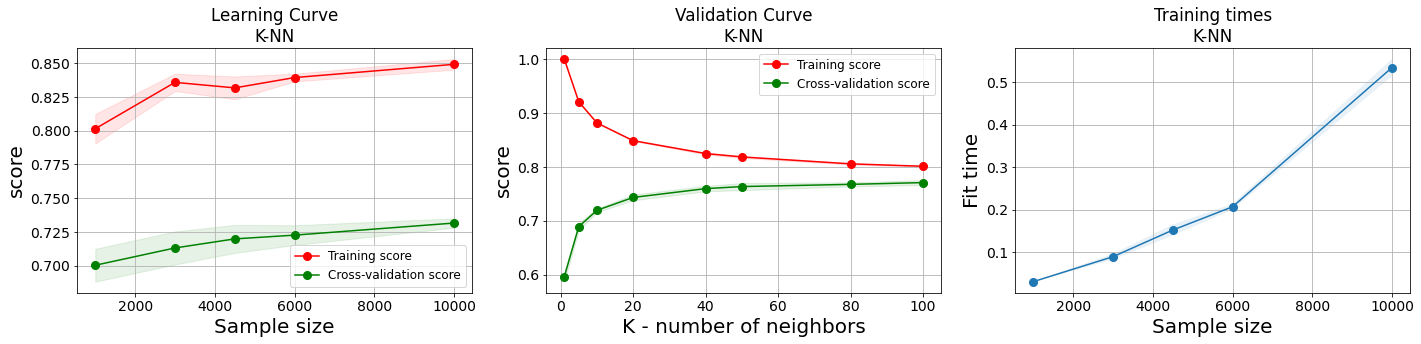

In [974]:
algoName = "K-NN"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 3, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title)

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 3, 2)
param_range = algoData[3]
train_scores, test_scores = results[algoName]['validation']
xlabel = "K - number of neighbors"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel)

# Score vs Fit-Time
#title = 'Performance\n' + algoName
#ax = figure.add_subplot(1, 3, 3)
#param_range = algoData[3]
#train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
#plots.plotScoreVsFitTime(fit_times, test_scores, ax, title)

# Training time
title = 'Training times\n' + algoName
ax = figure.add_subplot(1, 3, 3)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotSampleSizeVsFitTime(train_sizes, fit_times, ax, title)


figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "knn_val_curves_n.png")))

### Save the results

In [884]:
#pickle.dump(results, open("bank_data_cross_model_study.pkl", "wb"))

In [954]:
### Load the results

results = pickle.load(open("bank_data_cross_model_study.pkl", "rb"))

## Perform Random Grid Search to tune the parameter across each model

Set the distribution of parameters, based on the validation curves I have obtained before

In [878]:
randomSearchRes = {}

In [879]:
# Number of random searches
n_iter_search = 100

# Cross validation
cv = 4

# Scoring
scoring='roc_auc'



In [880]:
param_distribs = {'Classification Trees':{
                                            'min_samples_split': randint(low=1, high=1000),    
                                            'max_depth': randint(low=1, high=50),
                                            'pruneLevel': [None] + list(range(50)),
                                            },
                  'Neural Networks': {'hidden_layer_sizes' : [(2, ), 
                                                            (4, ), 
                                                            (8, ), 
                                                            (10, ), 
                                                            (20, ), 
                                                            (2, 2), 
                                                            (4, 2), 
                                                            (10, 5, 2), 
                                                           ]
                                     },
                  'AdaBoosting': {'n_estimators': randint(low=10, high=1000)},
                  'SVC': {'kernel': ['linear', 'rbf'], 'C':loguniform(a = 1e-5, b = 1e1)},
                  #'K-NN': {'n_neighbors': randint(low=1, high=500)}
                 }

In [881]:
for modelName, clfModel in [('Classification Trees', bank_data.PrunedTree(random_state=1)),                
                  
                ('Neural Networks', MLPClassifier()),
                  
                ('AdaBoosting', AdaBoostClassifier()),
                ('SVC', SVC()),
                  
                #('K-NN', KNeighborsClassifier())]:
    
    print(f'Doing {modelName}...')
    
    rnd_search = RandomizedSearchCV(clfModel, param_distributions=param_distribs[modelName],
                                    n_iter=n_iter_search, cv=cv, scoring=scoring, 
                                    random_state=1)

    random_search_res = rnd_search.fit(X_train, y_train)

    randomSearchRes[modelName] = random_search_res
    print(f'Doing {modelName}...Done!')
    

Doing Classification Trees...
Doing Classification Trees...Done!
Doing Neural Networks...


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Doing Neural Networks...Done!
Doing AdaBoosting...
Doing AdaBoosting...Done!
Doing SVC...
Doing SVC...Done!
Doing K-NN...


KeyboardInterrupt: 

### Save the results

In [885]:
#pickle.dump(randomSearchRes, open("bank_data_RandomizedSearchCV.pkl", "wb"))

In [882]:
randomSearchRes

{'Classification Trees': RandomizedSearchCV(cv=4, estimator=PrunedTree(random_state=1), n_iter=100,
                    param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CBFC255438>,
                                         'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CBFC255780>,
                                         'pruneLevel': [None, 0, 1, 2, 3, 4, 5,
                                                        6, 7, 8, 9, 10, 11, 12,
                                                        13, 14, 15, 16, 17, 18,
                                                        19, 20, 21, 22, 23, 24,
                                                        25, 26, 27, 28, ...]},
                    random_state=1, scoring='roc_auc'),
 'Neural Networks': RandomizedSearchCV(cv=4, estimator=MLPClassifier(), n_iter=100,
                    param_distributions={'hidden_layer_sizes': [(2,), (4,), (8,),
           

Do KNN separate, as it took a bit more time than other algorithms

In [889]:
n_iter_search = 50

rnd_search = RandomizedSearchCV(KNeighborsClassifier(), param_distributions={'n_neighbors': randint(low=50, high=500)},
                                    n_iter=n_iter_search, cv=cv, scoring=scoring, 
                                    random_state=1)
random_search_res = rnd_search.fit(X_train, y_train)
randomSearchRes['K-NN'] = random_search_res

In [890]:
for modelName in randomSearchRes.keys():
    print(modelName)
    bank_data.report_randomized_search(randomSearchRes[modelName].cv_results_, 2)


Classification Trees
Model with rank: 1
Mean validation score: 0.773 (std: 0.009)
Parameters: {'max_depth': 16, 'min_samples_split': 537, 'pruneLevel': 8}

Model with rank: 2
Mean validation score: 0.773 (std: 0.013)
Parameters: {'max_depth': 21, 'min_samples_split': 543, 'pruneLevel': 35}

Neural Networks
Model with rank: 1
Mean validation score: 0.787 (std: 0.008)
Parameters: {'hidden_layer_sizes': (10,)}

Model with rank: 2
Mean validation score: 0.785 (std: 0.009)
Parameters: {'hidden_layer_sizes': (8,)}

AdaBoosting
Model with rank: 1
Mean validation score: 0.779 (std: 0.008)
Parameters: {'n_estimators': 96}

Model with rank: 2
Mean validation score: 0.778 (std: 0.008)
Parameters: {'n_estimators': 81}

SVC
Model with rank: 1
Mean validation score: 0.727 (std: 0.007)
Parameters: {'C': 0.024858342346711446, 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: 0.726 (std: 0.010)
Parameters: {'C': 0.0006516215458215692, 'kernel': 'rbf'}

K-NN
Model with rank: 1
Mean validation 

### Save the results

In [891]:
pickle.dump(randomSearchRes, open("bank_data_RandomizedSearchCV.pkl", "wb"))

In [893]:
for modelName in randomSearchRes.keys():
    print(modelName)
    bank_data.report_randomized_search(randomSearchRes[modelName].cv_results_, 1)


Classification Trees
Model with rank: 1
Mean validation score: 0.773 (std: 0.009)
Parameters: {'max_depth': 16, 'min_samples_split': 537, 'pruneLevel': 8}

Neural Networks
Model with rank: 1
Mean validation score: 0.787 (std: 0.008)
Parameters: {'hidden_layer_sizes': (10,)}

AdaBoosting
Model with rank: 1
Mean validation score: 0.779 (std: 0.008)
Parameters: {'n_estimators': 96}

SVC
Model with rank: 1
Mean validation score: 0.727 (std: 0.007)
Parameters: {'C': 0.024858342346711446, 'kernel': 'rbf'}

K-NN
Model with rank: 1
Mean validation score: 0.769 (std: 0.009)
Parameters: {'n_neighbors': 171}



### Do a quick table

In [897]:
hyperParams = pd.DataFrame({'Algorithm': ['Trees with pruning', 
                                         'Neural Network',
                                          'AdaBoosting',
                                          'SVC',
                                          'K-NN'
                                         ],
                           'Optimal Parameter': ['max_depth: 16, min_samples_split: 537, pruneLevel: 8',
                                                "hidden_layer_sizes: (10,)",
                                                 "n_estimators: 96",
                                                 "C: 0.0248, kernel: rbf",
                                                 "n_neighbors: 171"
                                                ],
                           'Cross validated AUC score': ["77.3%", "78.7%", "77.9%", "72.7%", "76.9%"]})
hyperParams

,Algorithm,Optimal Parameter,Cross validated AUC score
0,Trees with pruning,"max_depth: 16, min_samples_split: 537, pruneLe...",77.3%
1,Neural Network,"hidden_layer_sizes: (10,)",78.7%
2,AdaBoosting,n_estimators: 96,77.9%
3,SVC,"C: 0.0248, kernel: rbf",72.7%
4,K-NN,n_neighbors: 171,76.9%


In [898]:
hyperParams.to_clipboard()

### Analyze the type of errors for AdaBoost

In [903]:
len(bestAdaBoost.feature_importances_)

50

In [904]:
X_train

array([[-0.93435875, -0.42856903,  1.58276737, ...,  0.        ,
         0.        ,  1.        ],
       [-1.02840691, -0.40385249,  1.58276737, ...,  0.        ,
         0.        ,  1.        ],
       [-0.93435875, -0.44768315, -0.69984772, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.6989898 , -0.44768315, -0.33943481, ...,  0.        ,
         0.        ,  0.        ],
       [-0.74626243, -0.44768315,  0.38139101, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.13470082,  0.27436927,  1.58276737, ...,  0.        ,
         0.        ,  1.        ]])

In [902]:
bestAdaBoost = randomSearchRes['AdaBoosting'].best_estimator_
bestAdaBoost.feature_importances_

array([0.07291667, 0.16666667, 0.17708333, 0.09375   , 0.14583333,
       0.03125   , 0.01041667, 0.        , 0.        , 0.01041667,
       0.        , 0.        , 0.        , 0.        , 0.01041667,
       0.        , 0.01041667, 0.        , 0.        , 0.01041667,
       0.01041667, 0.01041667, 0.        , 0.01041667, 0.        ,
       0.        , 0.        , 0.        , 0.02083333, 0.01041667,
       0.        , 0.        , 0.01041667, 0.01041667, 0.01041667,
       0.01041667, 0.01041667, 0.01041667, 0.01041667, 0.01041667,
       0.02083333, 0.01041667, 0.01041667, 0.01041667, 0.01041667,
       0.01041667, 0.        , 0.01041667, 0.03125   , 0.        ])

### Make a final evaluation in the test set

In [ ]:
Use all the data 

#### Understand Log-Uniform from scipy.stats
I noticed in the validation curve for SVC that it is better to use log-scale for the parameter C. I would like to use a uniform distribution over log-scales for C. I believe loguniform from scipy.stats may be able to provide that

In [745]:
lu = loguniform(a = 1e-5, b = 1e-1)

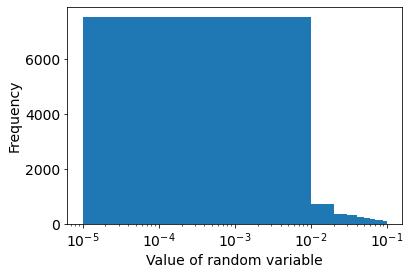

In [746]:
#### Plot the distribution of log-uniforms in log-scale
N = 10_000
r = lu.rvs(size=N)
fig, ax = plt.subplots(1, 1)
ax.hist(r)
ax.set_ylabel("Frequency")
ax.set_xlabel("Value of random variable")
ax.set_xscale('log')

Mmmm.. this is not what I would have expected... for some reason the distribution is not uniform above 10^-2, not sure why?

### Feature Importance

In [913]:
one_hot_columns = preprocess_pipeline.named_transformers_['categorical_pipeline'].get_feature_names(input_features=cat_columns)

In [914]:
featuresList = list(num_columns)
featuresList.extend(one_hot_columns)

In [920]:
feature_importances = eli5.explain_weights(bestAdaBoost, top=40, feature_names=featuresList)

In [928]:
feature_importances

Weight,Feature
0.1771 ± 0.7635,day
0.1667 ± 0.7454,balance
0.1458 ± 0.7059,pdays
0.0938 ± 0.5830,campaign
0.0729 ± 0.5200,age
0.0312 ± 0.3480,poutcome_success
0.0312 ± 0.3480,previous
0.0208 ± 0.2857,housing_yes
0.0208 ± 0.2857,month_jun
0.0104 ± 0.2031,month_nov


### Evaluate on the test set

In [947]:
import time

In [951]:
testSetResults = pd.DataFrame(index = randomSearchRes.keys(),
                             columns = ["Test AUC", "Precision", "Recall", "Running Time"])
for modelName in randomSearchRes.keys():
    print(modelName)
    clonedBest = clone(randomSearchRes[modelName].best_estimator_)
    if modelName == 'SVC':
        clonedBest.probability = True
    start = time.time()
    # Fit it to the entire train set
    clonedBest.fit(X = X_train, y = y_train)
    # Evaluate it on the test set
    y_pred_prob = clonedBest.predict_proba(X_test)
    y_pred = clonedBest.predict(X_test)
    end = time.time()
    auc_test       = roc_auc_score(y_true = y_test, y_score = y_pred_prob[:, 1])
    precision_test = precision_score(y_true = y_test, y_pred  = y_pred)
    recall_test    = recall_score(y_true = y_test, y_pred  = y_pred)
    
    testSetResults.loc[modelName, :] = [auc_test, precision_test, recall_test, end - start]

Classification Trees
Neural Networks
AdaBoosting
SVC


C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


K-NN


In [952]:
testSetResults

,Test AUC,Precision,Recall,Running Time
Classification Trees,0.785929,0.613527,0.219723,0.489984
Neural Networks,0.796715,0.631818,0.240484,15.5891
AdaBoosting,0.785414,0.635294,0.186851,8.66505
SVC,0.731096,0,0,643.869
K-NN,0.776798,0.770492,0.0813149,55.7683


Copy to Excel to make a table

In [953]:
testSetResults.to_clipboard()

In [944]:
cloned.probability

True

### Learning Curves and validation curves of tuned algorithms

In [987]:
cv = 4
train_sizes = [1000, 3000, 4500, 6000, 10000]
n_jobs      = -1
scoring     = 'roc_auc'

In [988]:
tunedModelsResults = {}

In [990]:
testSetResults = pd.DataFrame(index = randomSearchRes.keys(),
                             columns = ["Test AUC", "Precision", "Recall", "Running Time"])
for modelName in randomSearchRes.keys():
    print(modelName)
    clonedBest = clone(randomSearchRes[modelName].best_estimator_)    
    
    learning_curve_data = learning_curve(
                                    clonedBest,
                                     X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )
    
    # Get the data for the confusion matrix    
    clonedBest.fit(X_train, y_train)
    y_pred = clonedBest.predict(X_test)    
    
    tunedModelsResults[modelName] = {"learning_curve_data": learning_curve_data, 'y_pred': y_pred}
    
    print(modelName + "... done")

Classification Trees
Classification Trees... done
Neural Networks
Neural Networks... done
AdaBoosting
AdaBoosting... done
SVC
SVC... done
K-NN
K-NN... done


### Plot the learning curves and confusion matrices

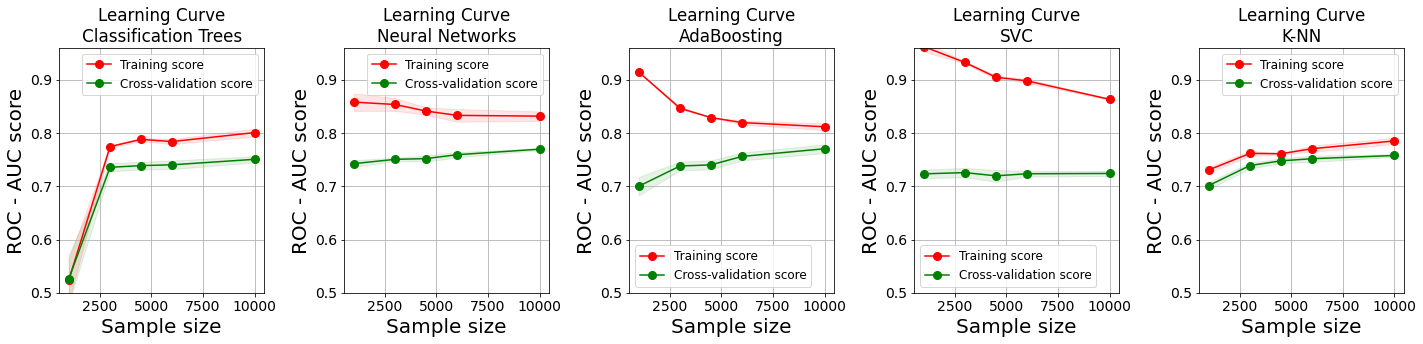

In [996]:
# PLot the final learning curves
figure = plt.figure(figsize = (20, 5))

for idx, modelName in enumerate(tunedModelsResults.keys()):
    
    ax = figure.add_subplot(1, 5, idx+1)
        
    # Plot Learning curve
    title = 'Learning Curve\n' + modelName    
    train_sizes, train_scores, test_scores, fit_times, _ = tunedModelsResults[modelName]['learning_curve_data']
    plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title, ylabel = 'ROC - AUC score')
    
    ax.set_ylim([0.5, 0.96])

figure.tight_layout()

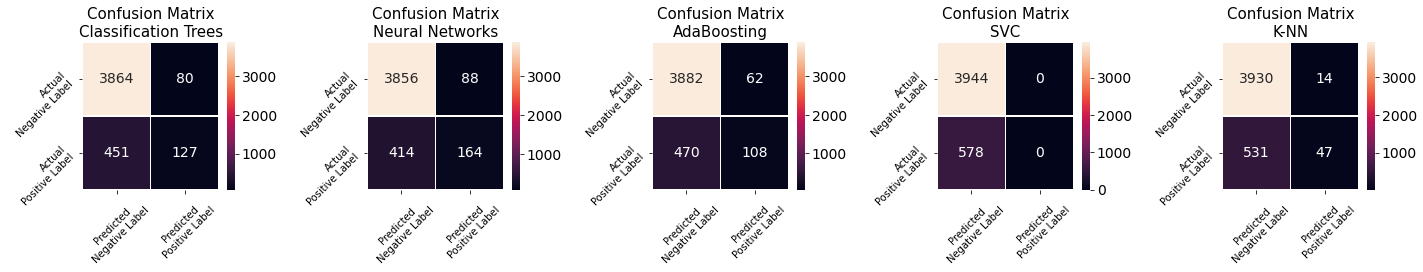

In [1002]:
# PLot the confusion matrices
figure = plt.figure(figsize = (20, 4))

for idx, modelName in enumerate(randomSearchRes.keys()):
    
    ax = figure.add_subplot(1, 5, idx+1)
        
    # Plot Learning curve
    title = 'Learning Curve\n' + modelName    
    y_pred = tunedModelsResults[modelName]['y_pred']
    title = "Confusion Matrix\n" + modelName
    plots.plot_confusion_matrix(y_pred, y_test, ax, title, ylabel = 'ROC - AUC score')

figure.tight_layout()

figure.savefig(os.path.join(os.path.join(OUTFIGURES, "confusion_matrices_tuned_models.png")))

### Plot the learning curves before and after parameter tunning

In [1013]:
results.keys()

dict_keys(['Decision tree - Max Depth', 'Decision tree - Prunning', 'Neural Network - depth', 'Neural Network - width', 'AdaBoostClassifier', 'SVC - Linear kernel', 'SVC - Radial Basis Function', 'K-NN', 'Neural Network - Learning rate', 'Neural Network - Learning rate - deep'])

In [1017]:
tunedModelsResults.keys()

dict_keys(['Classification Trees', 'Neural Networks', 'AdaBoosting', 'SVC', 'K-NN'])

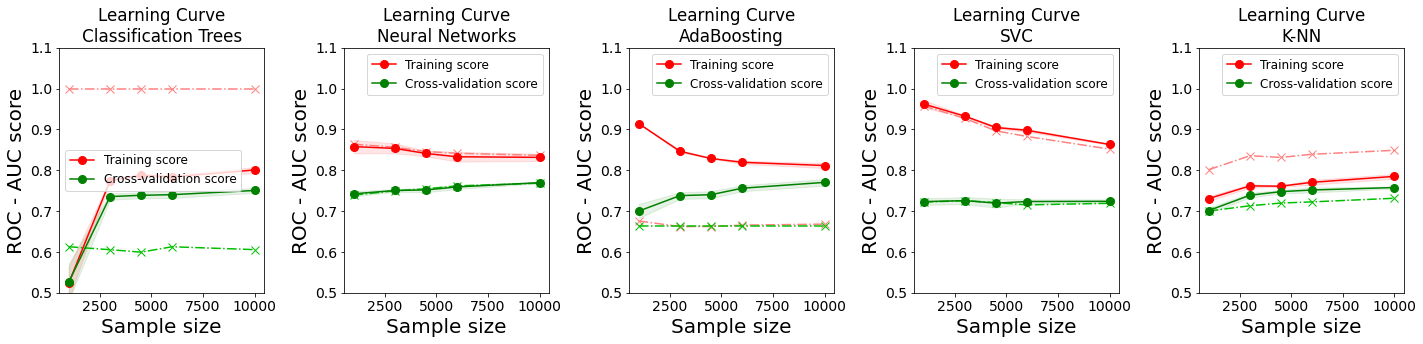

In [1041]:
# PLot the final learning curves
figure = plt.figure(figsize = (20, 5))

for idx, modelName in enumerate(tunedModelsResults.keys()):
    
    ax = figure.add_subplot(1, 5, idx+1)            
    
    # Plot Learning curve before parameter tunning
    title = 'Learning Curve\n' + modelName    
    nameForBeforeTunning = modelName
    if modelName == 'Classification Trees':
        nameForBeforeTunning = 'Decision tree - Max Depth'
    elif modelName == 'Neural Networks':
        nameForBeforeTunning = 'Neural Network - depth'
    elif modelName == 'AdaBoosting':
        nameForBeforeTunning = 'AdaBoostClassifier'
    elif modelName == 'SVC':
        nameForBeforeTunning = 'SVC - Radial Basis Function'
        
    train_sizes, train_scores, test_scores, fit_times, _ = results[nameForBeforeTunning]['learning']
    plots.plotLearningCurveBeforeTunning(train_sizes, train_scores, test_scores, ax, title, ylabel = 'ROC - AUC score')
    
    # Plot Learning curve after parameter tuning
    title = 'Learning Curve\n' + modelName    
    train_sizes, train_scores, test_scores, fit_times, _ = tunedModelsResults[modelName]['learning_curve_data']
    plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title, ylabel = 'ROC - AUC score')
    
    
    
    ax.set_ylim([0.5, 1.10])

figure.tight_layout()

figure.savefig(os.path.join(os.path.join(OUTFIGURES, "learning_curves_before_after_tunning.png")))

### Save the results

In [1011]:
pickle.dump(testSetResults, open("stock_data_testSetResults.pkl", "wb"))
pickle.dump(tunedModelsResults, open("stock_data_tunedModelsResults.pkl", "wb"))

Check this for AdaBoosting

In [1003]:
108 + 62

170

In [1000]:
# Check precision
108  / (108 + 62)

0.6352941176470588

In [1001]:
# Check recall
108  / (108 + 470)

0.18685121107266436

Yes! The above matches, indicating that the labels in the confusion matrices are correct

In [1007]:
325+64

389

In [1008]:
325 / (325 + 64)

0.8354755784061697

In [1009]:
325+56

381

In [1010]:
325 / (325 + 56)

0.8530183727034121

In [1042]:
fit_times

array([[0.03125453, 0.01562738, 0.03124642, 0.03124976],
       [0.10937476, 0.07812357, 0.09374738, 0.09000063],
       [0.1875    , 0.15625024, 0.15624976, 0.16300058],
       [0.25000191, 0.20312405, 0.20312238, 0.2040019 ],
       [0.51562405, 0.54687309, 0.57812643, 0.61688924]])

In [1043]:
train_scores

array([[0.74045851, 0.72739383, 0.72739383, 0.72739383],
       [0.76975097, 0.75920305, 0.75920305, 0.75920305],
       [0.7635706 , 0.76031852, 0.76031852, 0.76031852],
       [0.76043889, 0.7739309 , 0.7739309 , 0.7739309 ],
       [0.77497952, 0.78863167, 0.78864466, 0.78864466]])